# <center>Sistem Rekomendasi Anime Berbasis Hybrid Content-Based dan Collaborative Filtering<center>

## Import Modul

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, sigmoid_kernel
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

## Import Dataset

In [4]:
# Load dataset anime
animeDf = pd.read_csv('./dataset/anime.csv')
# Load dataset rating user
ratingDf = pd.read_csv('./dataset/rating.csv')

In [6]:
ratingDf.shape

(7813737, 3)

#### Deskripsi Dataset

Terdapat dua dataset yang digunakan, yaitu **anime.csv** dan **rating.csv**

**anime.csv** <br>
Dataset ini berisi informasi mengenai berbagai anime. Setiap baris dalam dataset mewakili satu anime. Dataset ini digunakan untuk analisis deskriptif dan sebagai input untuk sistem rekomendasi `Content Based Filtering`

**rating.csv** <br>
Dataset ini berisi penilaian yang diberikan oleh pengguna untuk berbagai anime. Setiap baris mewakili satu penilaian dari seorang user terhadap suatu anime. Dataset ini berguna untuk membuat sistem rekomendasi `Collaborative Filtering`, dimana pola penilaian pengguna dapat dianalisis untuk merekomendasikan anime yang mungkin disukai pengguna berdasarkan preferensi pengguna lain yang memiliki selera serupa.

### Informasi Dataset

In [3]:
# Keterangan dataset anime
print("Ukuran dataset Anime :", animeDf.shape)
animeDf.info()

Ukuran dataset Anime : (12294, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [4]:
# Rename column dalam dataset anime
animeDf.rename(columns={
    'name' : 'anime_title'
}, inplace=True)

# Convert kolom 'episodes' ke numerik
animeDf['episodes'] = pd.to_numeric(animeDf['episodes'], errors='coerce')

Terdapat 12.294 baris data yang terdiri dari 7 kolom berikut :
- **anime_id** : Unique id yang dimiliki suatu judul anime
- **name** : Judul dari anime
- **genre** : Genre dari suatu anime (dapat lebih dari 1)
- **type** : Jenis tayangan anime
- **eposides** : Jumlah episode dalam suatu judul anime
- **rating** : Nilai rating rata-rata (0-10)
- **members** : Jumlah anggota komunitas suatu anime

In [5]:
# Keterangan dataset rating
print("Ukuran dataset rating :", ratingDf.shape)
ratingDf.info()

Ukuran dataset rating : (1000000, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1000000 non-null  int64
 1   anime_id  1000000 non-null  int64
 2   rating    1000000 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


Terdapat 7.813.737 baris data yang terdiri dari 3 kolom berikut :
- **user_id** : Unique id yang dimiliki suatu user
- **anime_id** : Id dari anime yang di-rating
- **rating** : Rating yang diberikan user (0 - 10) *-1 jika user belum pernah merating*

## Exploratory Data Analysis

#### Penggabungan data Rating User terhadap Anime yang dirating

Penggabungan ini dilakukan untuk mengaitkan informasi dari kedua dataset. Langkah ini memungkinkan anaisis yang lebih mendalam seperti melihat hubungan antara genre dan rating, serta mempersiapkan data untuk pengembangan model rekomendasi yang efektif.

In [6]:
# Merge Data Anime dan User Rating
mergedData = pd.merge(animeDf, ratingDf, on='anime_id', suffixes=['', '_user'])

# Ukuran data yang sudah dimerge
print('Ukuran Data:', mergedData.shape)
mergedData.head() # Contoh DataFrame data yang sudah dimerge

Ukuran Data: (1000000, 9)


,anime_id,anime_title,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,278,-1


### Top 5 Anime Berdasarkan Banyaknya Rating

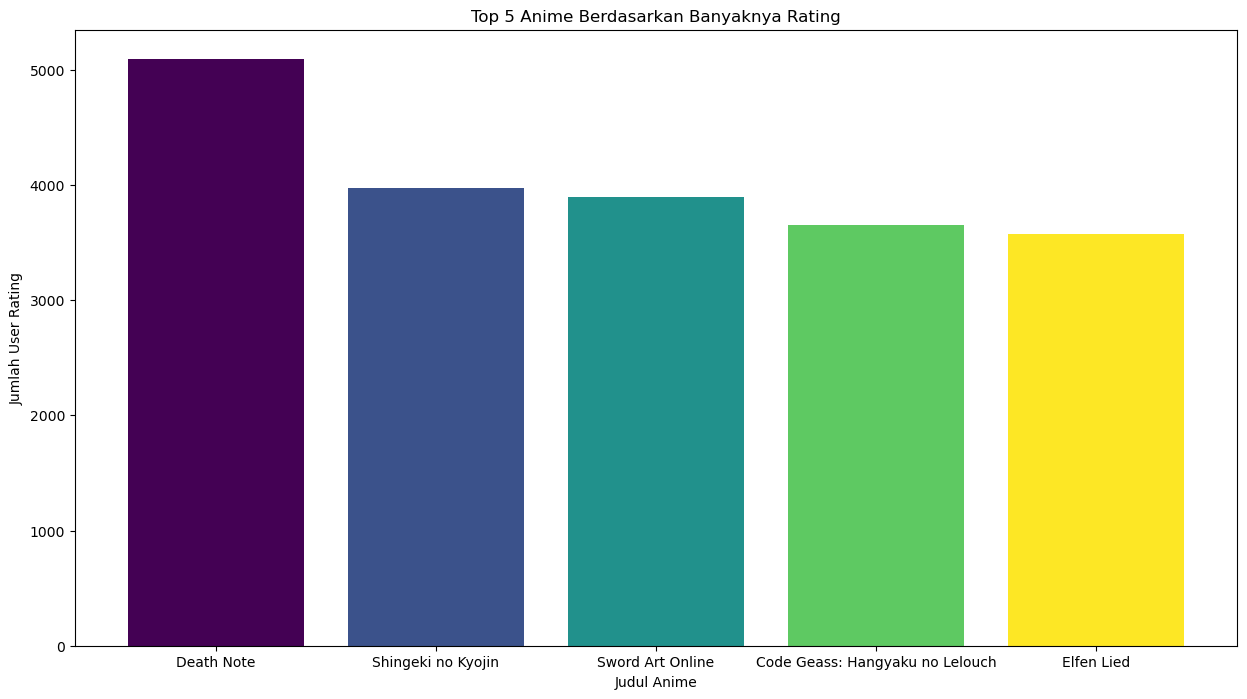

In [7]:
# Hitung jumlah rating setiap anime
ratingCount = mergedData.groupby(['anime_title'])['rating'].count().reset_index().rename(
    columns = {
        'rating' : 'totalRating'
    }
)

# Cari 5 anime dengan rating terbanyak
topRating = ratingCount.sort_values(by='totalRating', ascending=False).head(5)

# Plot hasil jumlah rating dan judul anime
plt.figure(figsize=(15,8))
plt.bar(topRating['anime_title'], topRating['totalRating'], color=plt.cm.viridis(np.linspace(0, 1, 5)))
# Keterangan Plot
plt.xlabel('Judul Anime')
plt.ylabel('Jumlah User Rating')
plt.title('Top 5 Anime Berdasarkan Banyaknya Rating')

# Cetak plot
plt.show()

Grafik di atas yang menunjukkan jumlah rating tertinggi mengindikasikan anime yang paling populer di kalangan pengguna. Informasi ini dapat digunakan sebagai dasar rekomendasi bagi pengguna baru, khususnya mereka yang belum memiliki history menonton maupun history rating. Dengan demikian, sistem rekomendasi dapat memberikan saran awal yang menarik dan relevan berdasarkan popularitas anime di kalangan komunitas pengguna.

In [8]:
# Tambahkan data total rating ke dalam dataframe
mergedData = mergedData.merge(ratingCount, left_on='anime_title', right_on='anime_title', how='left')
mergedData.rename(columns={
    'user_rating_x' : 'user_rating',
    'user_rating_y' : 'total_rating'
}, inplace=True)

### Top 5 Anime Berdasarkan Jumlah Anggota Komunitas

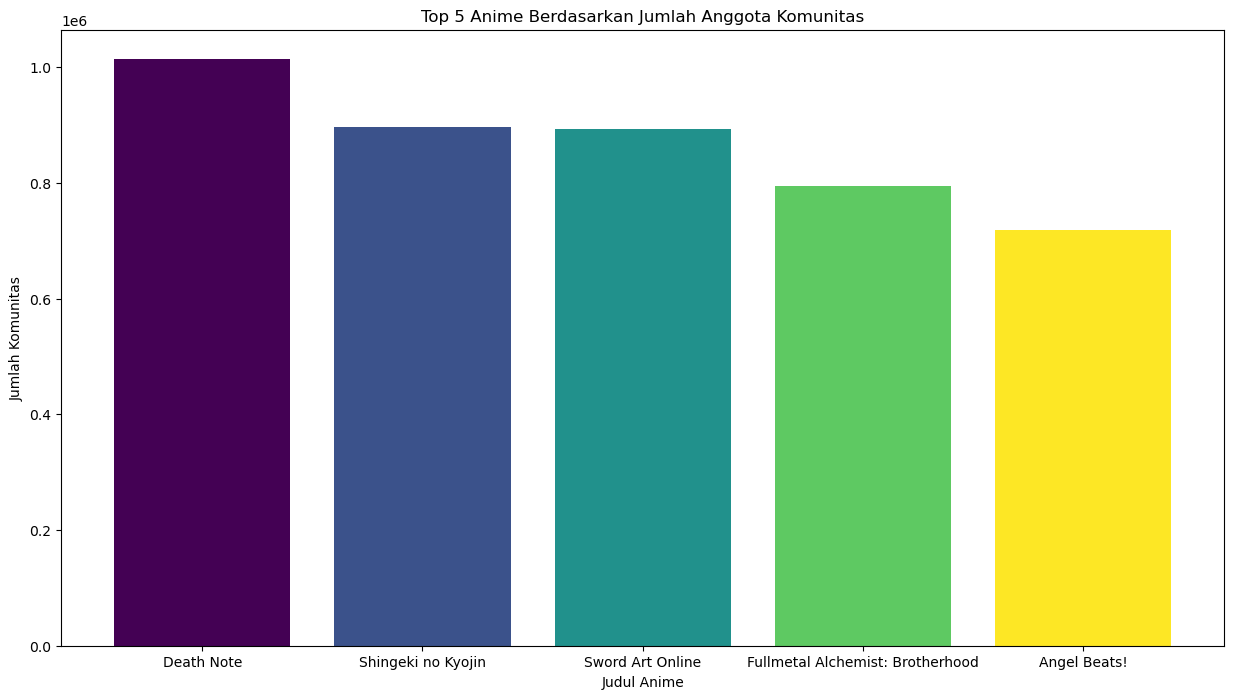

In [9]:
# Hapus data duplikat
topCommunity = mergedData.drop_duplicates(subset='anime_title', keep='first')
# Cari 5 komunitas terbesar dalam data
topCommunity = topCommunity[['anime_title', 'members']].sort_values(by='members', ascending=False).head(5)

# Plot hasil jumlah komunitas terbesar
plt.figure(figsize=(15,8))
plt.bar(topCommunity['anime_title'], topCommunity['members'], color=plt.cm.viridis(np.linspace(0, 1, 5)))
# Keterangan plot
plt.xlabel('Judul Anime')
plt.ylabel('Jumlah Komunitas')
plt.title('Top 5 Anime Berdasarkan Jumlah Anggota Komunitas')

# Cetak Plot
plt.show()

Anime seperti **Death Note**, **Shingeki no Kyojin**, dan **Sword Art Online** menempati posisi tertinggi dalam top 5 berdasarkan banyaknya rating dan top 5 berdasarkan banyaknya jumlah anggota komuintas. Hal tersebut mengindikasikan bahwa anime yang memiliki jumlah rating yang tinggi juga cenderung memiliki komunitas pengguna yang besar. Dengan memanfaatkan data popularitas berdasarkan rating dan jumlah anggota komunitas, sistem rekomendasi dapat memberikan saran yang lebih akurat dan relevan bagi pengguna.

### Distribusi Nilai Rating

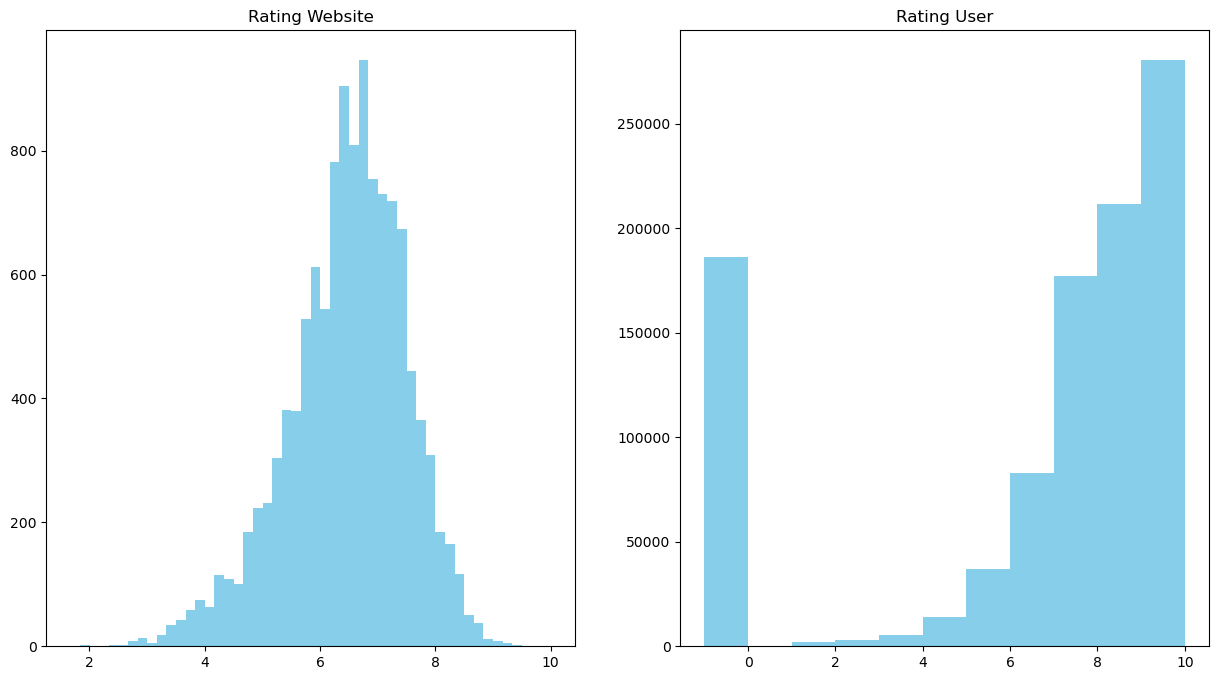

In [10]:
# Inisialisasi Plot
fig, ax = plt.subplots(1, 2, figsize=(15,8))

# Plot histogram rating dari website
ax[0].hist(animeDf['rating'], bins=50, color='skyblue')
ax[0].set_title('Rating Website')

# Plot histogram rating dari user
ax[1].hist(ratingDf['rating'], bins=11, color='skyblue')
ax[1].set_title('Rating User')

plt.show()

**Rating Website** mengacu pada rating rata-rata yang diberikan oleh seluruh pengguna untuk sebuah anime tertentu. Rating ini merupakan agregat dari semua penilaian individu yang diterima oleh anime tersebut dan memebrikan gambaran umum tentang seberapa baik anime tersebut diterima oleh komunitas secara keseluruhan.

**Rating User** merujuk pada rating yang diberikan oleh pengguna individu terhadap anime tertentu. Data ini lebih spesifik dan mencerminkan preferensi pribadi dari setiap pengguna.

Rating Website cenderung terpusat pada nilai 6 hingga 9, dengan puncak sekitar 7 dan 8. Ini menunjukkan bahwa anime secara umum dinilai cukup baik oleh pengguna di seluruh komunitas, dengan sebagian besar mendapatkan penilaian rata-rata yang cukup tinggi. Sedangkan rating user cenderung banyak yang menilai pada jangka 8 - 10. Hal ini dapat mencerminkan bahwa hanya anime dengan kualitas tertentu yang menarik cukup perhatian untuk dinilai secara luas.

Nilai -1 yang cukup banyak menunjukkan jumlah signifikan pengguna yang menambahkan anime ke daftar mereka tanpa memberikan rating. Ini mengindikasikan bahwa banyak pengguna yang berinteraksi dengan anime tersebut tetapi memilih untuk tidak memberikan penilaian numerik. Jumlah rating yang menonjol pada nilai yang tinggi dapat disebabkan oleh beberapa hal, diantaranya positive bias yang menyebabkan kecenderungan untuk memberikan nilai sangat tinggi dan efek popularitas anime tersebut yang memberikan motivasi untuk sesama memberikan feedback positif.

#### Korelasi Antara Rating Anime dengan Jumlah Membernya

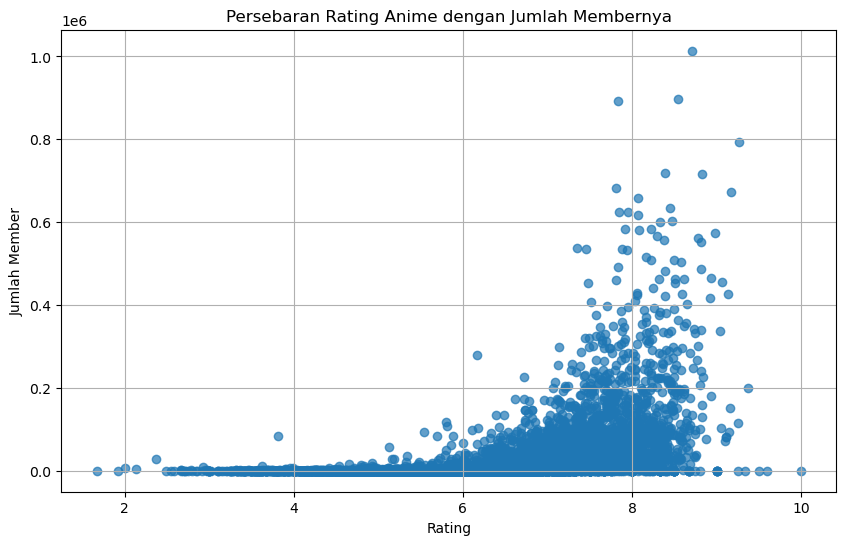

In [11]:
# Inisialisasi Plot
plt.figure(figsize=(10,6))

# Plot Scaterplot antara rating (x) dan jumlah member (y)
plt.scatter(animeDf['rating'], animeDf['members'], alpha=0.7)
# Keterangan Plot
plt.title('Persebaran Rating Anime dengan Jumlah Membernya')
plt.xlabel('Rating')
plt.ylabel('Jumlah Member')
plt.grid(True)

# Cetak Plot
plt.show()

Scatterplot diatas menunjukkan bahwa tidak ada korelasi linear yang kuat antara rating dan jumlah anggota (members). Meskipun anime dengan jumlah anggota yang banyak cenderung memiliki rating yang cukup baik, popularitas anie tidak selalu berbanding lurus dengan ratingnya. Ini menginidikasikan bahwa `terdapat faktor lain yang menentukan popularitas anime, selain dari rating yang diterima`.

### Persebaran Format Distribusi Anime

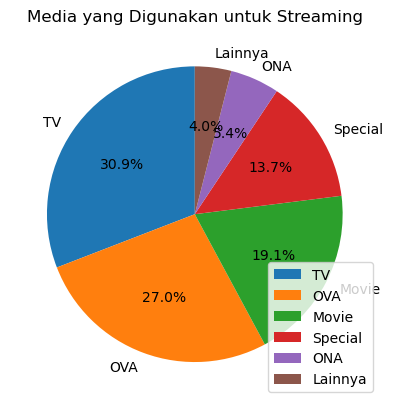

In [12]:
# Menghitung total jumlah jenis streaming
mediaTypeCount = animeDf['type'].value_counts()

# Menggabungkan nilai yang kurang dari 5% menjadi kategori 'others'
threshold = 0.05 * mediaTypeCount.sum() # Menghitung batas nilai 5%
smallCount = mediaTypeCount[mediaTypeCount < threshold] # Mengambil kategori yang kurang dari 5%
othersCount = smallCount.sum() # Menggabungkan seluruh kategori
mediaTypeCount = mediaTypeCount[mediaTypeCount >= threshold] # Mengambil kategori yang lebih dari 5%

if othersCount > 0 :
    mediaTypeCount['Lainnya'] = othersCount

# Plot pie chart
plt.pie(mediaTypeCount, labels=mediaTypeCount.index, autopct='%1.1f%%', startangle=90)
# Keterangan plot
plt.legend(mediaTypeCount.index, loc='lower right')
plt.title('Media yang Digunakan untuk Streaming')
plt.show()

Persebaran pada distribusi format seperti **TV**, **OVA**, dan **Movie** menunjukkan bahwa pengguna memiliki preferensi dalam menikmati konten anime. Sistem rekomendasi harus lebih fleksibel dan mampu memberikan rekomendasi yang bervariasi berdasarkan preferensi pengguna terhadapt berbagai format distribusi.

### Persebaran Jumlah Episode

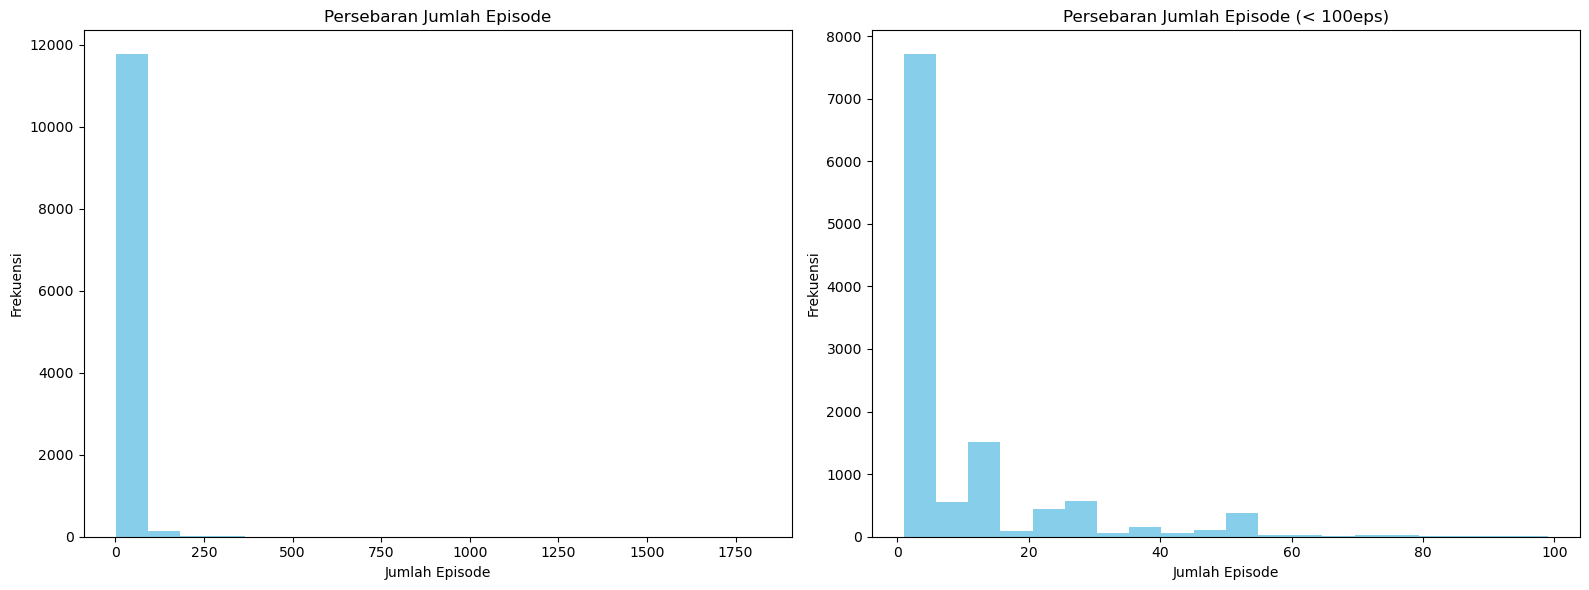

Jumlah Anime dengan Episode > 100: 159


In [13]:
# Inisialisasi plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot histogram Jumlah Episode
axes[0].hist(animeDf['episodes'], bins=20, color='skyblue')
axes[0].set_title('Persebaran Jumlah Episode')
axes[0].set_xlabel('Jumlah Episode')
axes[0].set_ylabel('Frekuensi')

# Plot histogram Jumlah Episode untuk episode kurang dari 100
axes[1].hist(animeDf.loc[animeDf['episodes'] < 100]['episodes'], bins=20, color='skyblue')
axes[1].set_title('Persebaran Jumlah Episode (< 100eps)')
axes[1].set_xlabel('Jumlah Episode')
axes[1].set_ylabel('Frekuensi')

# Cetak plot
plt.tight_layout()
plt.show()

print('Jumlah Anime dengan Episode > 100:', animeDf.loc[animeDf['episodes'] > 100].shape[0])


Dari histogram jumlah episode anime, terlihat bahwa mayoritas anime memiliki jumlah episode yang sedikit, dengan puncak tajam pada rentang 0 hingga 50 episode. Ini menunjukkan bahwa sebagian besar anime dibuat dalam format pendek. Hanya sedikit anime yang memiliki lebih dari 100 episode, yaitu sekitar 159 anime. Distribusi ini mengindikasikan bahwa format musim pendek sangat umum, dengan banyak serial yang dibuat dalam 12-13 episode (satu musim pendek) atau 24-26 episode (dua musim pendek).

Informasi ini penting karena menunjukkan perlunya memprioritaskan rekomendasi anime pendek yang lebih mungkin dsukai oleh pengguna yang mencari tontonan cepat. Namun, tetap penting untuk menyertakan beberapa rekomendasi anime panjang untuk pengguna yang menikmati cerita yang lebih mendalam.

#### Persebaran Jumlah Rating Yang Diberikan oleh User

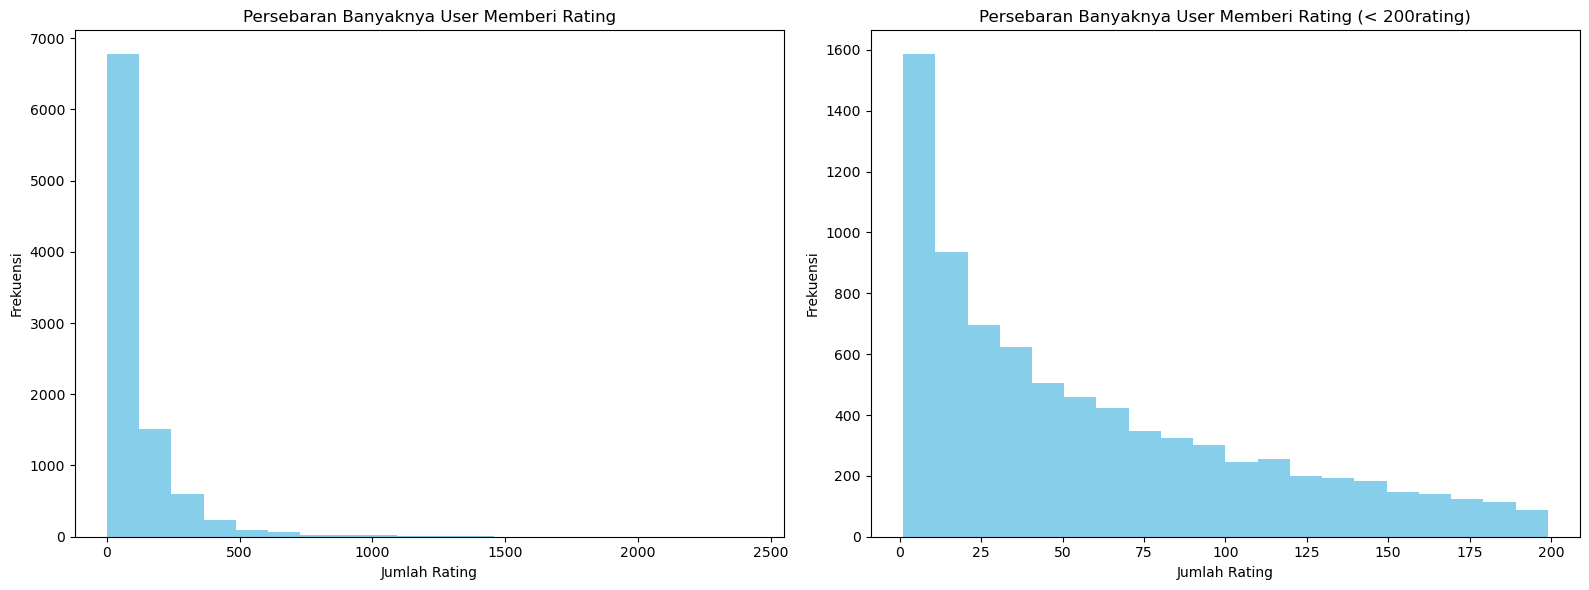

In [14]:
# Menghitung Jumlah Rating yang Diberikan oleh Setiap User
userRatingCount = ratingDf.groupby('user_id')['rating'].count()
userRatingCountFiltered = userRatingCount[userRatingCount < 200] # Filter Kurang dari 200

# Inisialisasi Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot histogram Jumlah User Memberikan Rating
axes[0].hist(userRatingCount, bins=20, color='skyblue')
axes[0].set_title('Persebaran Banyaknya User Memberi Rating')
axes[0].set_xlabel('Jumlah Rating')
axes[0].set_ylabel('Frekuensi')

# Plot histogram Jumlah User Memberikan Rating untuk Jumlah Rating kurang dari 200
axes[1].hist(userRatingCountFiltered, bins=20, color='skyblue')
axes[1].set_title('Persebaran Banyaknya User Memberi Rating (< 200rating)')
axes[1].set_xlabel('Jumlah Rating')
axes[1].set_ylabel('Frekuensi')

# Cetak plot
plt.tight_layout()
plt.show()

Dari histogram di atas, terlihat jelas bahwa partisipasi pengguna dalam memberikan rating sangat bervariasi, tetapi mayoritas cenderung memberikan hanya sedikit rating. Ini dapat berarti bahwa meskipun basis pengguna besar, kontribusi mereka dalam penilaian kontek mungkin terbatas. Dengan banyak pengguna yang memberikan sedikit rating, ini menciptakan masalah sparsity dalam data, yang dapat mempengaruhi akurasi model rekomendasi.

#### Persebaran Jumlah Rating oleh User yang Diterima Anime

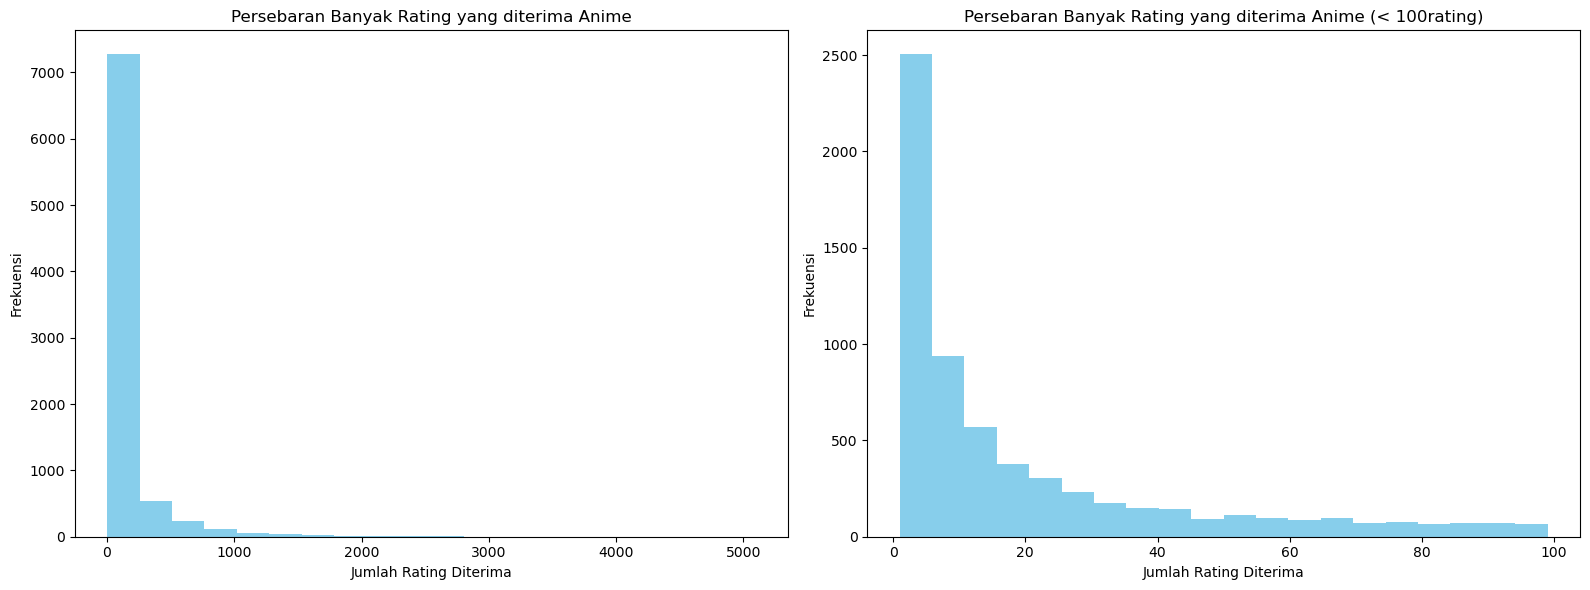

In [15]:
# Menghitung Jumlah Rating yang Diterima oleh setiap Anime
animeRatingCount = ratingDf.groupby('anime_id')['rating'].count()
animeRatingCountFiltered = animeRatingCount[animeRatingCount < 100] # Filter Kurang dari 100

# Inisialisasi Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot histogram Jumlah Rating Anime
axes[0].hist(animeRatingCount, bins=20, color='skyblue')
axes[0].set_title('Persebaran Banyak Rating yang diterima Anime')
axes[0].set_xlabel('Jumlah Rating Diterima')
axes[0].set_ylabel('Frekuensi')

# Plot histogram Jumlah Rating anime untuk rating kurang dari 100
axes[1].hist(animeRatingCountFiltered, bins=20, color='skyblue')
axes[1].set_title('Persebaran Banyak Rating yang diterima Anime (< 100rating)')
axes[1].set_xlabel('Jumlah Rating Diterima')
axes[1].set_ylabel('Frekuensi')

# Cetak plot
plt.tight_layout()
plt.show()

Dari histogram di atas, terlihat jelas bahwa popularitas anime sangat bervariasi, tetapi mayoritas anime cenderung menerima sedikit rating. Ini dapat berarti bahwa meskipun ada banyak anime yang tersedia, hanya beberapa yang benar-benar populer di kalangan pengguna. Hal ini juga menciptakan masalah sparsity dalam data, yang dapat mempengaruhi akurasi model.

### Kesimpulan Akhir dari EDA

Dari analisis EDA yang dilakukan, beberapa kesimpulan penting dapat diambil terkait distribusi dan preferensi user terhadap anime :

1. **Distribusi Format Anime** <br>
**TV** Merupakan yang paling dominan ($30.2\%$), diikuti oleh **OVA** ($27.4\%$), **Movie** ($19.1\%$), dan Special ($14.1\%$). Format lain seperti **ONA** dan kategori lainnya memiliki presentase yang lebih kecil. Ini menjunjukakn bahwa `meskipun TV tetap populer, ada diversifikasi yang signifikan dalam cara anime didistribusikan.`

2. **Distribusi Jumlah Episode** <br>
Mayoritas anime memiliki jumlah episode yang relatif sedikit, dengan puncak pada rentang 0 hingga 50 episode. Hanya sedikit anime yang memiliki lebih dari 100 episode (159 judul anime), menunjukkan bahwa `format musim pendek sangat umum dalam industri anime.`

3. **Rating dan Rating User** <br>
Rating Website cenderung terpusat pada nilai 6 hingga 9, dengan puncak sekitar 7 dan 8. Ini menunjukkan bahwa anime secara umum dinilai cukup baik oleh user di seluruh komunitas, dengan sebagian besar mendapatkan penilaian rata-rata yang cukup tinggi. Sedangkan rating user cenderung banyak yang menilai pada jangka 8 - 10. Hal ini dapat mencerminkan bahwa `hanya anime dengan kualitas tertentu yang menarik cukup perhatian untuk dinilai secara luas.`

4. **Persebaran Rating yang Diberikan** <br>
Terlihat jelas bahwa partisipasi user dalam memberikan rating dan popularitas anime sangat bervariasi, tetapi mayoritas user dan anime cenderung menerima sedikit rating. Ini mengindikasikan bahwa meskipun basis user besar dan banyak anime yang tersedia kontribusi user dalam penilaian konten mungkin terbatas dan hanya beberapa anime yang benar-benar populer di kalangan user. `Dengan banyaknya pengguna dan anime yang menerima sedikit rating, ini menciptakan masalah sparsity dalam data, yang dapat mempengaruhi akurasi model rekomendasi`


## <center>Collaborative Filtering<center>

### Data Preprocessing untuk Collaborative Filtering

Dalam **Collaborative Filtering**, format data yang digunakan untuk membuat rekomendasi adalah matrix user-anime, dimana setiap baris mewakili user dan kolom mewakili anime dengan value di dalam matriks menunjukkan rating yang diberikan oleh user tersebut.

Proses preprocessing data bertujuan untuk mengonversi data mentah menjadi format ini dan memastikan integritas serta keakuratan data. Agar martix yang dibuat dan hasil rekomendasi optimal, terdapat beberapa langkah yang dilakukan.

1. **Penghapusan Rating Tidak Valid** <br>
User yang tidak melakukan rating akan dihapus karena data tersebut tidak berarti dalam Collaborative Filtering yang akan dibangun dan akan menyebabkan meningkatnya noise dan tingkat komputasi yang dibutuhkan.

2. **Penghapusan Data Duplikat** <br>
Baris data yang duplikat hanya menambahkan bias dimana seolah-olah ada dua atau lebih user yang berbeda memberikan suatu rating, namun nyatanya data tersebut hanya merepresentasikan satu user saja.

3. **Penggabungan Data Anime dan Rating** <br>
Penggabungan dilakukan untuk integrasi anime dan user ke dalam satu DataFrame. Dengan menggabungkan data anime dan user, suatu anime dapat melihat bagaimana anime tersebut dirating oleh berbagai user dan suatu user dapat melihat kemiripan dengan user lain.

In [16]:
# Membuat data baru untuk dilakukan pre-processing
animeFeatureCF = animeDf.copy()
ratingFeatureCF = ratingDf.copy()

#### Menghapus pengguna dengan rating yang tidak valid

Rating yang tidak valid memiliki nilai -1 dan tidak berarti apa-apa untuk **Collaborative Filtering**, maka data rating tersebut akan dihapus

In [17]:
# Melihat jumlah nilai rating yang tidak valid pada data
print('Data rating dengan nilai rating -1 :', ratingFeatureCF.loc[ratingFeatureCF['rating'] == -1].shape[0])

# Menghapus baris data dengan rating -1
ratingFeatureCF = ratingFeatureCF.loc[ratingFeatureCF['rating'] != -1]

Data rating dengan nilai rating -1 : 186054


#### Menghapus Duplikat dalam Data

Data duplikat dihapus karena dapat menyebabkan bias dalam perhitungan similarity dan memperlambat proses komputasi karena harus menghitung titik data yang sama lebih dari sekali

In [18]:
# Menghitung jumlah duplikat di animeFeatureCF
print('Jumlah duplikat di animeFeatureCF:', animeFeatureCF.duplicated().sum())

# Menghitung jumlah duplikat di ratingFeatureCF
print('Jumlah duplikat di ratingFeatureCF:', ratingFeatureCF.duplicated().sum())

Jumlah duplikat di animeFeatureCF: 0
Jumlah duplikat di ratingFeatureCF: 0


In [19]:
# Menghapus data duplikat dari DataFrame
ratingFeatureCF.drop_duplicates(inplace=True)

#### Menghapus User yang Memberikan Rating Sedikit

In [20]:
# Melihat user dengan jumlah rating kurang dari 25
userRatingCount = ratingFeatureCF.groupby('user_id')['rating'].count()
usersWithLessRatings = userRatingCount[userRatingCount < 5].index

print('Jumlah user dengan rating kurang dari 25:', len(usersWithLessRatings))

# Menghapus user dengan rating kurang dari 25
ratingFeatureCF = ratingFeatureCF[~ratingFeatureCF['user_id'].isin(usersWithLessRatings)]


Jumlah user dengan rating kurang dari 25: 1101


#### Menghapus Anime yang Menerima Rating Sedikit

In [21]:
# Menghitung jumlah rating yang diterima setiap anime
animeRatingCount = ratingFeatureCF.groupby('anime_id').size()
# Mengambil data anime dengan rating lebih dari 50
animeRatingCountFiltered = animeRatingCount[animeRatingCount >= 10].index

# Mengambil hanya anime dengan jumlah rating lebih dari 50 pada kedua dataset
ratingFeatureCF = ratingFeatureCF[ratingFeatureCF['anime_id'].isin(animeRatingCountFiltered)]
animeFeatureCF = animeFeatureCF[animeFeatureCF['anime_id'].isin(animeRatingCountFiltered)]

#### Menggabungkan Data Anime dan Rating

Penggabungan dilakukan untuk mengintegrasikan data anime dan user sehingga dapat melihat kemiripan suatu user dengan user yang lain berasarkan rating yang diberikan oleh user tersebut

In [22]:
# Menggabungkan data anime dan rating
mergedData = pd.merge(animeFeatureCF, ratingFeatureCF, on='anime_id', suffixes=['', '_user'])

mergedData.head() # Contoh data yang sudah dimerge

,anime_id,anime_title,genre,type,episodes,rating,members,user_id,rating_user
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,322,10


### Weighted Collaborative Filtering

**Pengertian Collaborative Filtering** <br>
Collaborative Filtering adalah teknik dalam sistem rekomendasi yang menggunakan pola perilaku dan preferensi user untuk memprediksi anime yang mungkin disukai oleh user lain. Teknik ini memanfaatkan data rating yang diberikan user pada berbagai anime untuk menemukan kesamaan dalam preferensi dan memberikan rekomendasi yang relevan.
<br> <br>

**Kelebihan Collaborative Filtering** <br>
1. **Personalisasi yang Tinggi** <br>
Memberikan rekomendasi yang sangat dipersonalisasi berdasarkan preferensi user.
2. **Tidak Memerlukan Data Eksternal** <br>
Hanya membutuhkan data interaksi user dengan anime, tidak perlu informasi tambahan terkait anime atau user tersendiri.
3. **Adaptif** <br>
Dapat menyesuaikan dengan perubahan preferensi user dari waktu ke waktu.

**Kekurangan Collaborative Filtering** <br>
1. **Masalah Data Sparsity** <br>
Matriks user-anme sering kali sangat ebsar dan jarang terisi, hal ini dapat menyebabkan kebutuhan tingkat komputasi yang tinggi
2. **Cold Start Problem** <br>
Sulit memberikan rekomendasi akurat untuk user baru atau anime baru yang belum memiliki banyak rating
3. **Scalability** <br>
Mengelola dan menghitung kesamaan dalam dataset besar dapat membutuhkan tingkat komputasi yang tinggi.
<br><br>

**Collaborative Filtering dengan Cosine Similarity & Euclidean Distance** <br>
Collaborative Filtering dengan `Euclidean Distance` adalah metode dimana kesamaan antar user dihitung menggunakan metric Euclidean. Ini mengukur jarak garis lurus antara dua titik. Dengan ini, Euclidean Distance digunakan untuk mengukur seberapa mirip dua user atau anime berdasarkan rating yang diberikan. Semakin kecil jarak Euclidean, semakin mirip user tersebut terhadap user lain.

Jika dua user memberikan rating yang sangat mirip untuk beberapa anime, jarak Euclidean antara mereka akan kecil, menandakan bahwa preferensi mereka mirip. Berdasarkan ini, sistem rekomendasi dapat merekomendasikan anime yang disukai oleh satu user terhadap user lainnya.

Collaborative Filtering dengan `Cosine Similarity` adalah metode dimana kesamaan antar user dihitung menggunaakn metrik Cosine Similarity. Cosine Similarity mengukur kesamaan antara dua vektor dengan menghitung cosinus dari sudut di antara mereka. Ini sering digunakan karena mengabaikan magnitudo dan hanya mengabaikan pertimbangan orientasi, yang berguna dalam mengukur kesamaan pola rating meskipun skalanya berebeda.

Jika dua user memberikan rating yang memiliki pola serupa (suka atau tidak suka anime yang sama), maka Cosine Similarity antara mereka akan tinggi, menandakan bahwa preferensi mereka serupa. Berdasarkan ini, sistem rekomendasi dapat merekomendasikan anime yang disukai oleh suatu pengguna kepada pengguna lainnya.
<br><br>

**Weighted Collaborative Filtering** <br>
Model terbaik akan diimplementasikan suatu weight tertentu terhadap hasil rekomendasi. Ini dilakukan dengan menambahkan bobot pada anime tertentu berasarkan atribut atau kriteria tambahan untuk meningkatkan akurasi rekomendasi. Misalnya, dalam rekomendasi anime, sistem rekomendasi dapat memberikan bobot lebih pada anime dengan format populer (TV, OVA, Movie), rating tinggi, atau jumlah episode tertentu untuk meningkatkan relevansi rekomendasi.
<br><br>

**Skema Pengujian** <br>
Mean Absolute Error (MAE) akan digunakan sebagai metrik evaluasi utama untuk mengukur performa dari sistem rekomendasi yang dibuat. MAE mengukur seberapa besar rata-rata kesalahan antara rating yang diprediksi oleh model dan rating yang sebenarnya diberikan pengguna. Semakin rendah nilai MAE, semakin baik kinerja model dalam memprediksi. MAE memberikan gambaran sederhana namun efektif tentang akurasi prediksi model. `Model terbaik akan dipilih berdasarkan nilai MAE terkecil`
<br><br>

**Finetuning Weight pada Model Terbaik** <br>
Finetuning weight pada model terbaik akan dilakukan untuk meningkatkan kinerja model. Proses ini melibatkan penyesuaian bobot yang diberikan pada kriteria tertentu (format populer, rating tinggi, dan jumlah episode) untuk meningkatkan kinerja model. Proses ini dilakukan melalui grid search untuk menemukan kombinasi bobot terbaik. Grid search menguji berbagai kombinasi parameter untuk mengidentifikasi yang menghasilkan kinerja terbaik berdasarkan MAE.


#### Mengambil Data yang Relevan untuk Collaborative Filtering

Kolom `user_id` digunakan mengidentifikasi suatu user, sedangkan `anime_id` mengidentifikasi suatu anime, sedangkran `rating_user` menyediakan inforasi tentang penilaian user terhadap suatu anime. Informasi ini cukup untuk membentuk matrix user-anime atau pivot table yang menjadi dasar model.

Kolom lain seperti genre atau jumlah episode tidak diperlukan karena pada **Collaborative Filtering** berfokus pada pola kesamaan antara user dengan user lain.

In [23]:
# Mengambil kolom yang relevan
userRatings = mergedData[['user_id', 'anime_id', 'rating_user']]

# Menghapus data user yang memberi rating ke anime yang sama
userRatings = userRatings.drop_duplicates(subset=['user_id', 'anime_id'])

userRatings.head() # Contoh data yang digunakan

,user_id,anime_id,rating_user
0,99,32281,5
1,152,32281,10
2,244,32281,10
3,271,32281,10
4,322,32281,10


#### Split Data Latih dan Data Uji

Membagi data menjadi data latih dan data uji bertujuan untuk mengeevaluasi kinerja model secara objektif dan mencegah overfitting. **Data latih** digunakan untuk melatih model sehingga dapat mengenali pola dan hubungan dalam data, sedangkan **data uji** digunakan untuk menguji model yang telah dilatih untuk menilai performa dan generalisasi dari model tersebut.

Data uji yang digunakan hanya $1\%$ dari keseluruhan data, mengingat jumlah data yang mencapai jutaan dan masalah keterbatasan komputasi saat melakukan pengujian.

In [24]:
# Split data latih dan data uji
trainData, testData = train_test_split(userRatings, test_size=0.2, random_state=42)

# Cetak banyaknya data latih dan uji
print('Banyaknya data latih:', trainData.shape[0])
print('Banyaknya data uji:', testData.shape[0])

Banyaknya data latih: 640045
Banyaknya data uji: 160012


#### Membuat Pivot Table

Dalam Collaborative Filtering, pivot table digunakan untuk menyusun informasi user dan anime dalam format matriks, di mana baris mewakili anime dan kolom mewakili user. Nilai dalam pivot table ini adalah rating yang diberikan pengguna terhadap item tersebut, dimana 0 berarti user belum memberikan rating terhadap anime tersebut.

**Tujuan Pivot Table** <br>
1. **Struktur Data yang Jelas** <br>
Mengorganisasi data sehingga hubungan antara anime dan user menjadi lebih jelas.
2. **Kemudahan Perhitungan** <br>
Mempermuhdah perhitungan kesamaan antara pengguna karena dapat direpresentasikan menjadi vektor.

`allPivot` merupakan pivot table yang dibuat dari seluruh data rating pengguna. Ini digunakan untuk memastikan bahwa semua informasi rating tersedia dan digunakan untuk prediksi dalam model rekomendasi.

`trainPivot` merupakan pivot table yang dibuat dari data latih. Ini digunakan untuk melatih model rekomendasi, sehingga model dapat menangani pola-pola dalam data rating yang ada. Dengan memisahkan data latih, kita dapat mengukur kinerja model dengan uji coba secara objektif

In [25]:
# Membuat sparse matrix yang bersumber dari keseluruhan data
allPivot = userRatings.pivot(index='anime_id', columns='user_id', values='rating_user').fillna(0)
# membuat sparse matrix yang bersumber dari data latih
trainPivot = trainData.pivot(index='anime_id', columns='user_id', values='rating_user').fillna(0)

In [26]:
trainPivot.head() # Contoh sparse matrix

user_id,3,5,7,8,11,12,14,16,17,18,...,9347,9348,9349,9350,9351,9352,9353,9355,9356,9357
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
trainPivot.shape

(4565, 7756)

#### Membuat Compressed Sparse Row (CSR)

CSR adalah format penyimpanan matriks yang digunakan untuk menyimpan sparse matrix secara efisian dalam memori. CSR terdiri dari tiga komponen utama, yaitu
1. **Data**: Array satu dimensi yang berisi semua elemen non-nol dari matriks.
2. **Indices**: Array satu dimensi yang berisi indeks kolom untuk setiap elemen dalam array data.
3. **Index Pointer**: Array satu dimensi yang berisi indeks dalam array data yang memulai setiap baris dari matriks.

format CSR digunakan oleh SciKit Learn `NearestNeighbor` sebagai input data latih. Ini memungkinkan model untuk memanfaatkan struktur data yang lebih ringan dan lebih cepat dibandingkan sparse matrix.

In [28]:
# Buat CSR dari sparse matrix (pivot table)
allCSR = csr_matrix(allPivot.values)
trainCSR = csr_matrix(trainPivot.values)

#### Model dengan Euclidean Distance

**Euclidean Distance** adalah ukuran jarak garis lurus antara dua titik dalam ruang multidimensi. Ini digunakan untuk mengukur kemiripan antar user berdasrakan pola rating yang diberikan. Ini dihitung dari sparse matrix yang sudah dibuat.

**Cara Kerja Euclidean Distance**
1. **Menghitung Jarak Euclidean** <br>
Jarak Euclidean antara vektor rating pengguna dihitung untuk menentukan kemiripan mereka. Semakin kecil jaraknya, semakin mirip preferensi pengguna tersebut.
2. **Menemukan User Serupa** <br>
User yang memiliki jarak euclidean yang kecil mengindikasikan kemiripan antara dua user tersebut. Semakin kecil jaraknya, semakin mirip preferensi pengguna tersebut.
3. **Memberikan Rekomendasi** <br>
Setelah menemukan pengguna yang mirip, sistem memberikan rekomendasi berdasarkan anime yang diberi rating tinggi oleh user serupa yang belum pernah dirating oleh pengguna target.

In [29]:
# Membuat model euclidean berdasarkan CSR dari sparse matrix
modelEuclidean = NearestNeighbors(metric='euclidean')
modelEuclidean.fit(trainCSR)

NearestNeighbors(metric='euclidean')

In [30]:
def predictRatingEuclidean(userId, animeId):
    '''
    Fungsi ini digunakan untuk memprediksi rating yang mungkin diberikan oleh seorang
    pengguna terhadap suatu anime berdasarkan kesamaan Euclidean distance antara
    pengguna tersebut dengan pengguna lain.
    '''

    # Inisialisasi nilai rating
    predictedRating = 0

    # Mengecek apakah animeId ada dalam sparse matrix keseluruhan data
    if animeId in allPivot.index:
        # Mennghitung jarak Euclidean dan indeks neighbor terdekat
        distances, indices = modelEuclidean.kneighbors(allPivot.loc[animeId, :].values.reshape(1, -1), n_neighbors=8)
        similarUsers = indices.flatten() # Mendapatkan user yang serupa

        # Cek apakah userId ada dalam kolom dari keselurhan data
        if userId in allPivot.columns:
            # Mengambil rating yang diberikan oleh pengguna yang mirip
            userRatings = allPivot.iloc[similarUsers, allPivot.columns.get_loc(userId)]
            # Jika ada rating dari pengguna yang mirip, hitung rata-rata rating tersebut
            if userRatings.sum() > 0:
                predictedRating = userRatings[userRatings > 0].mean()
            else:
                # Jika tidak ada rating, gunakan rata-rata rating semua pengguna untuk anime tersebut
                predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
        else:
            # Jika userId tidak ada dalam kolom gunakan rata-rata rating seluruh pengguna untuk semua anime
            predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
    else:
        # Jika animeId tidak ditemukan, gunakan rata-rata rating seluruh pengguna terhadap seluruh anime
        predictedRating = allPivot.loc[:, allPivot > 0].mean(axis=1).mean()

    # Mengembalikan rating yang diprediksi
    return predictedRating

In [31]:
def recommendAnimeEuclidean(userId, n_recommendations=5):
    '''
    Fungsi ini digunakan untuk merekomendasikan anime kepada pengguna berdasarkan
    jarak Euclidean antara pengguna tersebut dengan pengguna lain. Fungsi ini
    mengembalikan sejumlah rekomendasi anime yang mirip dengan preferensi peungguna.
    '''

    # Mengecek apakah userId ada dalam kolom dari allPivot
    if userId not in allPivot.columns:
        # Jika userId tidak ditemukan, kembalikan DataFrame kosong
        return pd.DataFrame({'anime_id': [], 'anime_title': [], 'rating': []})

    # Mendapatkan indeks kolom dari userId dalam keseluruhan data
    userIndex = allPivot.columns.get_loc(userId)

    # Menghitung jarak Euclidean dan indeks neightbor terdekat dari userId yang diberikan
    distances, indices = modelEuclidean.kneighbors(allPivot.T[userIndex].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    # List kosong untuk menampung rekomendasi anime
    recommendations = []

    # Iterasi untuk mendapatkan rekomendasi
    for i in range(1, len(distances.flatten())):
        # Mendapatkan animeId dari indeks yang direkomendasikan
        animeId = allPivot.index[indices.flatten()[i]]
        # Mengambil data dari anime 
        animeRow = animeFeatureCF[animeFeatureCF['anime_id'] == animeId].iloc[0]
        # Mendapatkan prediksi rating
        predictedRating = predictRatingEuclidean(userId, animeId)
        # Menambahkan data anime ke dalam list
        recommendations.append((animeId, animeRow['anime_title'], round(predictedRating, 2)))

    # Mengembalikan rekomendasi dalam format DataFrame
    recommendations = pd.DataFrame(recommendations, columns=['anime_id', 'anime_title', 'predicted_rating'])
    return recommendations.sort_values(by='predicted_rating', ascending=False)

In [32]:
def topRatedAnimeByUser(userId, top_n=5):
    '''
    Fungsi ini digunakan untuk mendapatkan daftar sejumlah anime yang diberikan
    oleh user tertentu.
    '''

    # Filter data rating berdasarkan UserId yang diberikan
    userRatingsFiltered = userRatings[userRatings['user_id'] == userId]

    # Mengambil sejumlah anime dengan rating tertinggi dari user yang sudah ditentukan
    topRated = userRatingsFiltered.nlargest(top_n, 'rating_user')

    # Menggabungkan data rating tertinggi dengan judul anime berdasarkan anime_id
    topRatedWithNames = topRated.merge(animeDf[['anime_id', 'anime_title']], on='anime_id')

    # Mengembalikan DataFame daftar anime dengan rating tertinggi
    return topRatedWithNames[['anime_id', 'anime_title', 'rating_user']]

Contoh prediksi model dengan metode `Euclidean Distance`

In [71]:
try :
    # Ambil contoh rekomendasi untuk satu user
    cosineExample = recommendAnimeEuclidean(5)
except :
    cosineExample = None
    print('NotFound')

cosineExample

,anime_id,anime_title,predicted_rating
0,5,Cowboy Bebop: Tengoku no Tobira,8.40
2,227,FLCL,8.18
1,6,Trigun,8.00
4,47,Akira,8.00
3,205,Samurai Champloo,7.33


In [34]:
topRatedAnimeByUser(5)

,anime_id,anime_title,rating_user
0,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,10
1,245,Great Teacher Onizuka,10
2,9253,Steins;Gate,9
3,9969,Gintama&#039;,9
4,918,Gintama,9


#### Model dengan Cosine Similarity

**Cosine Similarity** adalah ukuran kesamaan antara dua vektor dalam ruang multidimensi dengan menghitung cosinus dari sudut di antara mereka. Dalam konteks Collaborative Filtering, Cosine Similarity digunakan untuk mengukur seberapa mirip dua pengguna berdasrakan pola rating yang diberikan dengan mengabaikan magnitudo dan hanya mempertimbangkan orientasi.

**Cara Kerja Cosine Similarity**
1. **Menghitung Nilai Similarity** <br>
Cosine similarity A dan B dihitung, dimana vektor rating dari dua pengguna akan memiliki hasil antara -1 dan 1. Nilai -1 berarti kedua user memiliki preferensi yang berlawanan, sedangkan nilai 0 berarti kedua user tidak memiliki kesamaan sama sekali, dan 1 berarti kedua user memiliki preferensi yang sama persis.

2. **Menemukan Pengguna Serupa** <br>
Pengguna dengan nilai Cosine Similarity tertinggi dianggap sebagai yang paling mirip. Model `NearestNeighbor` digunakan untuk menemukan pengguna serupa ini berdasarkan kesamaan Cosine.

3. **Memberikan Rekomendasi** <br>
Setelah menemukan pengguna yang mirip, sistem memberikan rekomendais item kepada pengguna target berdasarkan item yang diberi rating tinggi oleh pengguna yang mirip tersebut. Item yang belum ditonton oleh pengguna terget namun memiliki rating tinggi dari pengguna serupa akan direkomendasikan.

In [35]:
# Buat Object Model Sklearn Nearest Neighbor dengan metode cosine similarity
modelCosine = NearestNeighbors(metric='cosine')

# Masukkan data kepada model
modelCosine.fit(trainCSR)

NearestNeighbors(metric='cosine')

In [36]:
def predictRatingCosine(userId, animeId):
    '''
    Fungsi ini digunakakn untuk memprediksi rating yang mungkin diberikan oleh seseorang
    pengguna terhadap suatu anime berdasarkan kesamaan sudut Cosine antara pengguna
    tersebut dengan pengguna lain
    '''

    # Inisialisasi nilai rating
    predictedRating = 0

    # Mengecek apakah animeId ada dalam sparse matrix keseluruhan data
    if animeId in allPivot.index:
        # Menghitung sudut Cosine Similarity dan indeks sudut terdekat
        distances, indices = modelCosine.kneighbors(allPivot.loc[animeId, :].values.reshape(1, -1), n_neighbors=4)
        similarUsers = indices.flatten()

        # Cek apakah userId ada dalam kolom dari keseluruhan data
        if userId in allPivot.columns:
            # Mengambil rating yang diberikan oleh pengguna yang mirip
            userRatings = allPivot.iloc[similarUsers, allPivot.columns.get_loc(userId)]
            # Jika ada rating dari pengguna yang mirip, hitung rata-rata rating tersebut
            if userRatings.sum() > 0:
                predictedRating = userRatings[userRatings > 0].mean()
            else:
                # Jika tidak ada rating, gunakan rata-rata rating semua pengguna untuk anime tersebut
                predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
        else:
            # Jika userId tidak ada dalam kolom, gunakan rata-rata rating seluruh pengguna untuk semua anime
            predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
    else:
        # Jika animeId tidak ditemukan, gunakan rata-rata rating seluruh pengguna terhadap seluruh anime
        predictedRating = allPivot.loc[:, allPivot > 0].mean(axis=1).mean()

    # Mengembalikan rating yang diprediksi
    return predictedRating

In [37]:
def recommendAnimeCosine(userId, n_recommendations=5):
    '''
    Fungsi ini digunakan untuk merekomendasikan anime kepada pengguna berdasarkan
    besar sudut Cosine antara pengguna tersebut dengan pengguna lain. Fungsi ini
    mengembalikan sejumlah rekomendasi anime yang mirip dengan preferensi peungguna.
    '''

    # Mengecek apakah userId ada dalam kolom dari allPivot
    if userId not in allPivot.columns:
        # Jika userId tidak ditemukan, kembalikan DataFrame kosong
        return pd.DataFrame({'anime_id': ['user not found'], 'anime_title': ['user not found'], 'rating': ['user not found']})

    # Mendapatkan indeks kolom dari userId dalam keseluruhan data
    userIndex = allPivot.columns.get_loc(userId)
    
    # Menghitung sudut cosine dan indeks neighbor terdekat dari userId yang diberikan
    distances, indices = modelCosine.kneighbors(allPivot.T[userIndex].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    # List kosong untuk menampung rekomendasi anime
    recommendations = []

    # Iterasi untuk mendapatkan rekomendasi
    for i in range(1, len(distances.flatten())):
        # Mendapatkan animeId dari indeks yang direkomendasikan
        animeId = allPivot.index[indices.flatten()[i]]
        # Mengambil data dari anime
        animeRow = animeDf[animeDf['anime_id'] == animeId].iloc[0]
        # Mendapatkan prediksi rating
        predictedRating = predictRatingEuclidean(userId, animeId)
        # Menambahkan data anime ke dalam list
        recommendations.append((animeId, animeRow['anime_title'], round(predictedRating, 2)))

    # Mengembalikan rekomendasi dalam format DataFrame
    recommendations = pd.DataFrame(recommendations, columns=['anime_id', 'anime_title', 'predicted_rating'])
    return recommendations.sort_values(by='predicted_rating', ascending=False)

In [38]:
def topRatedAnimeByUser(userId, top_n=5):
    '''
    Fungsi ini digunakan untuk mendapatkan daftar sejumlah anime yang diberikan
    oleh user tertentu.
    '''

    # Filter data rating berdasarkan UserId yang diberikan
    userRatingsFiltered = userRatings[userRatings['user_id'] == userId]

    # Mengambil sejumlah anime dengan rating tertinggi dari user yang sudah ditentukan
    topRated = userRatingsFiltered.nlargest(top_n, 'rating_user')

    # Menggabungkan data rating tertinggi dengan judul anime berdasarkan anime_id
    topRatedWithNames = topRated.merge(animeDf[['anime_id', 'anime_title']], on='anime_id')

    # Mengembalikan DataFame daftar anime dengan rating tertinggi
    return topRatedWithNames[['anime_id', 'anime_title', 'rating_user']]

Contoh prediksi model dengan metode `Cosine Similarity`

In [39]:
try :
    # Ambil contoh rekomendasi untuk satu user
    cosineExample = recommendAnimeCosine(5)
except :
    cosineExample = None
    print('NotFound')

cosineExample

,anime_id,anime_title,predicted_rating
0,5,Cowboy Bebop: Tengoku no Tobira,8.40
3,227,FLCL,8.18
2,6,Trigun,8.00
1,205,Samurai Champloo,7.33
4,30,Neon Genesis Evangelion,4.50


In [40]:
# Top 5 rating dari user sebagai referensi
topRatedAnimeByUser(5)

,anime_id,anime_title,rating_user
0,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,10
1,245,Great Teacher Onizuka,10
2,9253,Steins;Gate,9
3,9969,Gintama&#039;,9
4,918,Gintama,9


#### Pengujian Model

**Mean Absolute Error** (MAE) adalah metrik yang digunakan pada pengujian ini untuk mengevaluasi kinerja model sistem rekomendasi yang dibuat. MAE mengukur rata-rata kesalahan absolut antara rating yang diprediksi dan rating sebenarnya. Nilai MAE yang rendah menunjukkan bahwa model memiliki kinerja yang baik dalam memprediksi rating.

Dalam pengujian ini, MAE digunakan untuk membandingkan akurasi prediksi antara model yang menggunakan `Euclidean Distance` dan `Cosine Similarity`, sehingga dapat menentukan model mana yang lebih efektif memberikan rekomendasi yang lebih akurat.

In [41]:
# Hitung MAE untuk model dengan Euclidean Distance
predictedRatingEuclidean = testData.apply(lambda row: predictRatingEuclidean(row['user_id'], row['anime_id']), axis=1)
mae_euclidean = mean_absolute_error(testData['rating_user'], predictedRatingEuclidean)
print(f"Mean Absolute Error (MAE) for Euclidean model: {mae_euclidean}")

# Hitung MAE untuk model dengan Cosine Similarity
predictedRatingCosine = testData.apply(lambda row: predictRatingCosine(row['user_id'], row['anime_id']), axis=1)
mae_cosine = mean_absolute_error(testData['rating_user'], predictedRatingCosine)
print(f"Mean Absolute Error (MAE) for Cosine model: {mae_cosine}")

Mean Absolute Error (MAE) for Euclidean model: 0.37376140241862815
Mean Absolute Error (MAE) for Cosine model: 0.44519108983492917


#### Hasil Pengujian dan Kesimpulan

Berdasarkan hasil pengujian, model **Collaborative Filtering** yang menggunakan `Euclidean Distance` menunjukkan kinerja yang lebih baik dibandingkan dengan model yang menggunakan **Cosine Similarity**. Hasil MAE yang lebih rendah pada model Euclidean Distance mengindikasikan bahwa prediksi model ini lebih mendekati rating aktual yang diberikan oleh pengguna, sehingga model ini lebih akurat dalam memberikan rekomendasi.

**Euclidean Distance** lebih efektif dibandingkan **Cosine Similarity** dalam Collaborative Filtering pada kasus ini karena Euclidean Distance lebih sensitif terhadap perbedaan dalam skala rating yang diberikan oleh pengguna. Pada dataset ini, pengguna mungkin memiliki skala penilaian yang lebih seragam atau konsisten, sehingga perbedaan kecil dalm skala lebih signifikan dalam mempengaruhi rekomendasi. Dengan demikian, Euclidean Distance berhasil menangkap perbedaan kecil dalam rating, yang ternyata lebih relevan dalam memprediksi preferensi pengguna dibandingkan hanya mengukur kesamaan pola atau oritentasi rating seperti yang dilakukan oleh Cosine Similarity.

#### Fine Tuning dengan Weight

**Fine Tuning dengan Weight** dalam sistem rekomendasi bertujuan untuk menyesuaikan bobot pada berbagai aspek tertenu seperti genre, tipe, dan jumlah episode guna meningkatkan akurasi dan relevansi rekomendasi yang diberikan. Misalnya, genre mungkin memiliki pengaruh besar akrena pengguna cenderung memiliki preferensi genre tertentu. Oleh karena itu, memberikan bobot lebih tinggi pada genre dapat meningkatkan kualitas rekomendasi. Berikut adalah data faktor dari weight yang diberikan.

1. **Genre** <br>
Banyak user yang memiliki preferensi kuat terhadap genre tertentu, sehingga memberikan bobot pada genre dapat meningkatkan relevansi rekomendasi. Genre juga mencerminakn tema dan gaya umum dari anime, yang merupakan faktor utama yang memengaruhi apakah seorang user akan menyukai anime tersebut atau tidak.

2. **Type** <br>
Type juga merupakan faktor penting karena berbeda tipe anime menawarkan pengalaman menonton yang berbeda. Misalnya user mungkin lebih menyukai anime dengan format TV yang memiliki episode berkelanjutan, atau lebih menyukai Movie karena durasinya yang lebih singkat dan cerita yang padat. Dengan memberikan weight pada tipe, sistem rekomendasi dapat menyesuaikan rekomendasi untuk lebih mencocokkan format anime dengan preferensi user.

3. **Episodes** <br>
Jumlah episode dapat memengaruhi daya tarik suatu anime. Beberapa user lebih menyukai anime dengan episode singkat karena lebih mudah untuk diikuti, sementara yang lain mungkin lebih tertarik pada anime dengan banyak episode karena memberikan cerita yang lebih mendalam dan pengembangan karakter yang lebih luas. Dengan menyesuakan weight berdasarkan jumlah episode, sistem rekomendasi dapta lebih sesuai dengan preferensi durasi menonton user.

**Pengaruh Weight dalam Hasil Rekomenasi** cukup signifikan. Weight yang diterapkan pada aspek-aspekt ertenu dapat mengubah prioritas rekomendasi yang diberikan oleh sistem. Selain itu, finetuning weight memungkinkan sistem untuk menyesuaikan rekomendasi berdasarkan tren dan preferensi yang sedang berkembang

In [42]:
def getGenreWeight(animeId, factor=1):
    '''
    Fungsi untuk mendapatkan weight dari suatu genre tertentu
    '''
    try :
        # Mengambil genre dari anime berdasarkan animeId yang diberikan
        genre = animeFeatureCF[animeFeatureCF['anime_id'] == animeId]['genre'].iloc[0]
        
        # Mendefinisikan bobot untuk setiap genre
        genre_weights = {
            'Action': 1.35,
            'Adventure': 1.3,
            'Comedy': 1.25,
            'Drama': 1.1,
            'Fantasy': 1,
            'Romance': 0.95,
            'Sci-Fi': 0.9,
            'Slice of Life': 0.875,
            'Horror': 0.85,
            'Mystery': 0.825,
        }

        # Memisahkan genre menjadi list (genre dapat lebih dari satu)
        genres = genre.split(', ')

        # Menghitung rata-rata weight dari semua genre yang dimiliki oleh anime
        weight = sum([genre_weights.get(g, 0.1) for g in genres]) / len(genres)
        
        # Mengembalikan bobt yang dikalikan oleh faktor
        return weight * factor

    # Mengembalikan 0 jika genre tidak ada dalam daftar
    except :
        return 0

def getTypeWeight(animeId, factor=1):
    '''
    Fungsi untuk mendapatkan weight dari suatu type tertentu
    '''
    try :
        # Mengambil tipe anime berdasarkan animeId yang diberikan
        anime_type = animeFeatureCF[animeFeatureCF['anime_id'] == animeId]['type'].iloc[0]

        # Mendefinisikan weight untuk setiap anime
        type_weights = {
            'TV': 1.2,
            'Movie': 1.15,
            'OVA': 1.05,
            'Special': 1,
            'ONA': 0.95,
            'Music': 0.9,
        }
        
        # Mengembalikan weight dari anime yang kemudian dikalikan dengan faktor
        return type_weights.get(anime_type, 0.1) * factor

    # Mengembalikan 0 jika tipe tidak ada dalam daftar
    except :
      return 0

def getEpisodesWeight(animeId, factor=1):
    '''
    Fungsi untuk mendapatkan weight berdasarkan jumlah episode
    '''

    # Mengambil jumlah episode dari anime berdasarkan animeId yang dibberikan
    episodes = int(animeFeatureCF[animeFeatureCF['anime_id'] == animeId]['episodes'].iloc[0])

    # Mengembalikan weight berdasrkan jumlah episode berdasarkan aturan yang ditentukan
    if episodes <= 12:
        return 0.95 * factor
    elif episodes <= 24:
        return 1.1 * factor
    elif episodes <= 50:
        return 0.9 * factor
    elif episodes <= 100:
        return 0.85 * factor
    else:
        return 0.825 * factor

In [43]:
def predictRatingEuclideanWeighted(userId, animeId, genreFactor=1, typeFactor=1, episodesFactor=1) :
    '''
    Fungsi ini memprediksi rating yang akan diberikan oleh userId terhadap suatu animeId
    dengan mempertimbangkan weight berdasarkan genre, tipe, dan jumlah episode. Fungsi ini
    menggunakan jarak Euclidean untuk menemukan user yang mirip dan menghitung rata-rata rating
    dari pengguna yang serupa. Rating kemudian disesuaikan dengan weight dari aspek tersebut
    '''
    
    # Inisialisasi nilai rating
    predictedRating = 0

    # Mendapatkan bobot dari masing-masing aspek
    genreWeight = getGenreWeight(animeId, factor=genreFactor)
    typeWeight = getTypeWeight(animeId, factor=typeFactor)
    episodesWeight = getEpisodesWeight(animeId, factor=episodesFactor)
    
    # Mendapatkan rata-rata nilai rating
    weights = (genreWeight + typeWeight + episodesWeight) / 3

    # Mengecek apakah animeId ada dalam sparse matrix keseluruhan data
    if animeId in allPivot.index:
        # Mennghitung jarak Euclidean dan indeks neighbor terdekat
        distances, indices = modelEuclidean.kneighbors(allPivot.loc[animeId, :].values.reshape(1, -1), n_neighbors=2)
        similarUsers = indices.flatten() # Mendapatkan user yang serupa

        # Cek apakah userId ada dalam kolom dari keselurhan data
        if userId in allPivot.columns:
            # Mengambil rating yang diberikan oleh pengguna yang mirip
            userRatings = allPivot.iloc[similarUsers, allPivot.columns.get_loc(userId)]
            # Jika ada rating dari pengguna yang mirip, hitung rata-rata rating tersebut
            if userRatings.sum() > 0:
                predictedRating = userRatings[userRatings > 0].mean()
            else:
                # Jika tidak ada rating, gunakan rata-rata rating semua pengguna untuk anime tersebut
                predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
        else:
            # Jika userId tidak ada dalam kolom gunakan rata-rata rating seluruh pengguna untuk semua anime
            predictedRating = allPivot.loc[animeId, allPivot.loc[animeId, :] > 0].mean()
    else:
        # Jika animeId tidak ditemukan, gunakan rata-rata rating seluruh pengguna terhadap seluruh anime
        predictedRating = allPivot.loc[:, allPivot > 0].mean(axis=1).mean()

    # Mengalikan prediksi rating dengan bobot yang diperoleh
    predictedRating *= weights

    # Mengembalikan rating yang diprediksi
    return predictedRating


In [44]:
def recommendAnimeEuclideanWeighted(userId, nRecommendations=3, genreFactor=1, typeFactor=1, episodesFactor=1):
    '''
    Fungsi ini memberikan rekomendasi anime untuk suatu userId berdasarkan jarak Euclidean ke penggun lain
    yang memiliki rating serupa. Fungsi ini menghasilkan daftar rekomendasi anime dengan rating yang diprediksi
    dengan mempertimbangkan bobot dari genre, tipe, dan jumlah episode.
    '''

    # Jika userId tidak ditemukan maka kembalikan DataFrame kosong
    if userId not in allPivot.columns:
        return pd.DataFrame({'anime_id': [], 'anime_title': [], 'rating': []})

    # Mendapatkan indeks dari userId di dalam sparse matrix
    userIndex = allPivot.columns.get_loc(userId)

    # Menghitung jarak Euclidean dan mendapatkan indeks user terdekat
    distances, indices = modelEuclidean.kneighbors(allPivot.T[userIndex].values.reshape(1, -1), n_neighbors=nRecommendations+1)
    
    # Inisialisasi list untuk menyimpan rekomendasi
    recommendations = []

    # Loop untuk setiap neighbor
    for i in range(1, len(distances.flatten())):
        # Mendapatkan animeId dari indeks
        animeId = allPivot.index[indices.flatten()[i]]

        # Mendapatkan data anime berdasarkan animeId
        animeRow = animeDf[animeDf['anime_id'] == animeId].iloc[0]

        # Memprediksi rating dari anime yang diberikan
        predictedRating = predictRatingEuclideanWeighted(
            userId, animeId, 
            genreFactor=genreFactor,
            typeFactor=typeFactor,
            episodesFactor=episodesFactor
        )

        # Menambahkan data anime kedalam list rekomendasi yang akan diberikan
        recommendations.append((animeId, animeRow['anime_title'], round(predictedRating, 2)))

    # Mengembalikan rekomendasi dalam bentuk DataFrame
    recommendations = pd.DataFrame(recommendations, columns=['anime_id', 'anime_title', 'predicted_rating'])
    return recommendations.sort_values(by='predicted_rating', ascending=False)


In [45]:
# Nilai faktor yang akan ditinjua untuk faktor bobot genre, tipe, dan jumlah episode
genreFactors = [0.15, 0.2, 0.25]
typeFactors = [1.65, 1.7, 1.75]
episodesFactors = [0.875, 0.9, 0.825]

# Inisialisasi list untuk menampung hasil
results = []

# Looping untuk setiap kombinasi weight
for genreFactor in genreFactors:
    for typeFactor in typeFactors:
        for episodesFactor in episodesFactors:\
            
            # Memprediksi ratng yang ditinjau
            predictedRatingWeighted = testData.apply(
              lambda row: predictRatingEuclideanWeighted(row['user_id'],
                                                      row['anime_id'],
                                                      genreFactor=genreFactor,
                                                      typeFactor=typeFactor,
                                                      episodesFactor=episodesFactor), axis=1)

            # Menghitung Mean Absolute Error (MAE) antara rating yang diprediksi dengan rating asli
            maeCosine = mean_absolute_error(testData['rating_user'], predictedRatingWeighted)
            # Masukkan hasil grid search ke dalam list penampung hasil
            results.append((genreFactor, typeFactor, episodesFactor, round(maeCosine,4)))

# Buat hasil ke dalam DataFrame
results = pd.DataFrame(results, columns=['Genre', 'Type', 'Episodes', 'MAE Score'])

# Sort DataFrame berdasarkan hasil MAE
results.sort_values(by='MAE Score', inplace=True)

results # Show DataFrame

,Genre,Type,Episodes,MAE Score
6,0.15,1.75,0.875,0.3750
13,0.20,1.70,0.900,0.3794
7,0.15,1.75,0.900,0.3802
17,0.20,1.75,0.825,0.3804
21,0.25,1.70,0.875,0.3838
26,0.25,1.75,0.825,0.3857
12,0.20,1.70,0.875,0.3877
15,0.20,1.75,0.875,0.3883
22,0.25,1.70,0.900,0.3917
4,0.15,1.70,0.900,0.3924


#### Kesimpulan Akhir

Dari hasil **Grid Search** diatas dapat dilihat bahwa pembobotan berpengaruh terhadap performa model rekomendasi. Berdasarkan EDA yang sudah dilakukan, pembobotan diberikan kepada genre, tipe, dan jumlah episode tertentu dimana setiap kategori diberikan bobot tertentu berdasarkan nilai kateogri tersebut. 

Dari hasil **Grid Search** yang dilakukan, pembobotan dengan rasio [0.15]:[1.75]:[0.875] memiliki nilai **MAE** terkecil. Hal tersebut menandakan bahwa preferensi user cenderung memiliki preferensi terhadap tipe tertentu.

**Rekomendasi Dengan Metode Euclidean Distance dengan Menggunakan Weight**

In [72]:
# Rekomendasi menggunakan weight terbaik
recommendAnimeEuclideanWeighted(5, nRecommendations=5, genreFactor=0.15, typeFactor=1.75, episodesFactor=0.875)

,anime_id,anime_title,predicted_rating
0,5,Cowboy Bebop: Tengoku no Tobira,8.32
1,6,Trigun,8.17
4,47,Akira,7.89
2,227,FLCL,7.53
3,205,Samurai Champloo,6.98


**Rekomendasi Dengan Metode Euclidean Distance tanpa Menggunakan Weight**

In [73]:
# Rekomendasi tanpa menggunakan weight
recommendAnimeEuclidean(5, n_recommendations=5)

,anime_id,anime_title,predicted_rating
0,5,Cowboy Bebop: Tengoku no Tobira,8.40
2,227,FLCL,8.18
1,6,Trigun,8.00
4,47,Akira,8.00
3,205,Samurai Champloo,7.33


Dilihat dari contoh rekomendasi diatas, film yang direkomendasikan terlihat mirip. Namun, urutan dari film yang direkomendasikan tersebut berubah. Hal tersebut mengindikasikan bahwa weight berpengaruh terhadap rekomendasi yang diberikan.

Secara keseluruhan, evaluasi menunjukkan bahwa **Collaborative Filtering** dengan menggunakan **Euclidean Distance** dan fine tuning menggunakan weight adalah pendekatan yang sangat efektif untuk memberikan rekomendasi anime yang akurat dan relevan. Model ini berhasil menangkap kesamaan antara pengguna dengan mempertimbangkan jarak dalam skala rating merka. Melalui pendekatan ini, perbedaan kecil dalam rating dapat diidentifikasi, sehingga pengguna dengan preferensi yang serupa dapat saling memberikan rekomendasi.

Implementasi dan hasil akhir dari pengujian ini dapat menjadi dasar untuk pengembangan lebih lanjut, termasuk menggunakan **Collaborative Filtering** dengan Content-Based Filtering untuk mengatasi keterbatasan masing-masing pendekatan dan memberikan hasil yang lebih akurat.

## <center>Content Based Filtering<center>

**Content Based Filtering** adalah metode dalam sistem rekomendasi yang memberikan rekomendasi kepada user berdasarkan konten antara item yang dipilih. Metode ini menggunakan fitur dari item atau dalam konteks ini adalah fitur dari anime seperti judul, genre, jumlah episode, dan lain-lain untuk menemukan anime yang mirip satu sama lain.

**Content Based Filtering** bekerja dengan menganalisis fitur-fitur konten dari setiap anime, seperti `genre`, `type`, `jumlah episode`, `rating` dan `jumlah anggota`. Sistem ini kemudian merekomendasikan anime yang memiliki karakteristik serupa dengan anime yang sudah disukai atau ditonton user. Metode ini tidak bergantung pada data user lain, sehingga tetap bisa memberikan rekomendasi yang relevan meskipun data user terbatas.

### Data Preprocessing untuk Content Based Filtering
Model **Content-Based Filtering** memerlukan data yang deskriptif tentang item yang akan direkomendasikan. Dalam konteks anime, model ini akan merekomendasikan anime kepada user berdasarkan kesamaan antara anime yang telah dinikmati oleh user dan karakteristik dari anime lainnya. Oleh karena itu, dilakukan pengolahan pada data untuk membuat data anime dapat diterima oleh model content based yang dibuat. Berikut adalah preprocessing yang dilakukan

1. **Membersihkan Judul Anime** <br>
Judul anime sering kali memiliki tanda baca, spasi tambahan, atau kata-kata yang tidak relevan untuk dijadikan fitur. Membersihkan judul dapat dilakukan dengan menghapus karakter yang tidak diperlukan, seperti tanda kurung, dan mengubah semua huruf menjadi huruf kecil untuk konsistensi.

2. **Penghapusan Nilai NULL** <br>
Nilai NULL dapat menggangu proses analisis. Oleh karena itu, perlu dilakukan penghapusan nilai NULL.

3. **Filtering Anime Berdasarkan Nilai Rating**
Anime dengan rating yang sangat rendah mungkin tidak relevan untuk digunakan dalam model rekomendasi. Oleh karena itu, kita bisa menyaring anime dengan rating dibawah nilai tertentu.

4. **Filtering Anime Berdasarkan Jumlah Member** <br>
Anime dengan jumlah member yang sedikit mungkin tidak signifikan untuk analisis. Filtering berdasarkan jumlah member membantu memastikan hanya anime yang cukup populer saja yang dipertimbangkan.

5. **Normalisasi Genre** <br>
Genre anime merupakan daftar yang dipisahkan oleh koma. Oleh karena itu, genre dinormalisasi dengan menghapus tanda baca seperti koma dan mengubahnya menjadi lowercase.

6. **Normalisasi Tipe** <br>
Normalisasi dengan mengubah tipe ke dalam lowercase juga dilakukan untuk menjaga konsistensi dengan fitur lainnya.

7. **Pengkategorisasian Episode, Rating, dan Member** <br>
Mengubah data numerik seperti episode, rating, dan jumlah member menjadi kategori dalam bentuk kata dilakukan untuk menyederhanakan dan menangkap pola secara lebih intuitif dalam data.

8. **Penggabungan Data Menjadi Satu Filter** <br>
Setelah preprocessing dilakukan, semua fitur yang telah dinormalisasi dan dikategorisasi dapat digabungkan menjadi satu representasi fitur yang dapat digunakan untuk pelatihan model.

In [48]:
# Copy DataFrame asli untuk dilakukan preprocessing
animeFeatureCB = animeDf.copy()

#### Membersihkan Judul Anime

Ini bertujuan unutk merapikan judul anime dalam dataset dengan menghapus atau mengganti karakter khusus dan pola teks yang tidak relevan. `RegEx` digunakan untuk mengganti pola tertentu menjadi bentuk yang lebih sederhana untuk memudahkan pemrosesan lebih lanjut.

In [49]:
# Function untuk membersihkan teks anime_title
def cleanTitle(text) :
    '''
    Fungsi ini bertujuan untuk membersihkan teks judul anime dari berbagai pola yang tidak
    diinginkan atau tidak perlu, serta merapikan spasi dan tanda baca. Ini berguna untuk
    memastikan konsistensi dalam teks judul.
    '''
    
    # Definisi pola teks dan penggantinya dalam format RegEx
    cleanPattern = {
        r'&quot;': '',              # Menghapus entitas HTML untuk tanda kutip
        r'.hack//': '',             # Menghapus pola .hack//
        r'&#039;': "'",             # Mengubah entitas HTML untuk tanda kutip tunggal
        r'&amp;': 'and',            # Mengubah entitas HTML untuk tanda '&'
        r'\s+': ' ',                # Menghapus spasi ekstra
        r'\s*:\s*': ': ',           # Menyusun ulang spasi sebelum dan sesudah tanda titik dua
        r'\s*-+\s*': ' - ',         # Menyusun ulang spasi sebelum dan sesudah tanda hubung
        r'\s*\(\w+\)\s*': '',       # Menghapus teks dalam tanda kurung (seperti "(TV)", "(OVA)")
        r'\s*movie\s*\d*': '',      # Menghapus teks "movie" dan angka setelahnya
        r'\s*ova\s*\d*': '',        # Menghapus teks "OVA" dan angka setelahnya
        r'\'s\b': '',               # Menghapus possessive 's
        r'\W+': ' ',                # Menghapus karakter non-alfabet
    }

    # Mengaplikasikan pembersihan judul yang diberikan pada seluruh pola
    for pattern, replacement in cleanPattern.items():
        text = re.sub(pattern, replacement, text)

    # Mengembalikan teks yang sudah dibersihkan
    return text.lower()

# Bersihkan seluruh judul anime dalam dataset
animeFeatureCB['anime_title_normalized'] = animeFeatureCB['anime_title'].apply(cleanTitle)

|Sebelum Cleaning|Sesudah Cleaning|
|----------------|----------------|
|Gintama'|Gintama|
|Steins;Gate: OVA|Steins Gate|
|Fullmetal Alchemist: Brotherhood|Fullmetal Alchemist Brotherhood|
|Naruto: Shippuden Movie 6 - Road to Ninja|Naruto Shippuden Road to Ninja|

Hasil diatas menunjukkan bahwa proses **text cleaning** berhasil menghilangkan karakter dan menghilangkan kata yang tidak relevan. Dengan menghilangkan elemen-elemen tersebut, judul anime lebih sederhana

#### Penghapusan Nilai NULL
Penghilangan data yang memiliki nilai NULL dilakukan untuk memastikan data yang digunakan dalam analisis atau model tidak mengandung kekosongan yang bisa menyebabkan error atau bias dalam hasil.

In [50]:
# Memeriksa nilai null dalam dataset
animeFeatureCB.isnull().sum()

anime_id                    0
anime_title                 0
genre                      62
type                       25
episodes                  340
rating                    230
members                     0
anime_title_normalized      0
dtype: int64

Dari hasil diatas dapat dilihat bahwa kolom rating dan episode memiliki nilai NULL yang cukup signifikan. Jika data dengan nilai null tersebut tidak dihapus, sistem rekomendasi tidak dapat melihat kesamaan jumlah episode atau rating dari data reference.

In [51]:
# Menghapus data NULL dalam data anime
animeFeatureCB.dropna(inplace=True)

#### Filter Anime Berdasarkan Nilai Rating
Filtering pada rating dilakukan unutk memastikan bahwa rekomendasi yang dilakukan memberikan kualitas anime yang tinggi dan disukai oleh user. Filtering ini membantu meningkatkan relevansi hasil dengan mengecualikan anime yang dianggap kurang baik.

In [52]:
# Filter anime dengan rating kurang dari 5
print('Banyaknya anime dengan rating kurang dari 5 :', animeFeatureCB.loc[animeFeatureCB['rating'] < 5].shape[0])

# Filter anime dengan rating >= 5
animeFeatureCB = animeFeatureCB.loc[animeFeatureCB['rating'] >= 5]

Banyaknya anime dengan rating kurang dari 5 : 936


#### Filter Anime Berdasarkan Jumlah Member

Filter ini bertujuan untuk mempertahankan anime yang memiliki jumlah tertentu untuk memastikan bahwa rekomendasi yang diberikan difokuskan pada animeyang lebih populer dan memiliki basis penggemar yang cukup.

In [53]:
# Lihat jumlah anime dengan members < 100
print('Banyaknya anime dengan rating kurang dari 2500 :', animeFeatureCB.loc[animeFeatureCB['members'] < 100].shape[0])

# Filter anime dengan member >= 100
animeFeatureCB = animeFeatureCB.loc[animeFeatureCB['members'] >= 100]

Banyaknya anime dengan rating kurang dari 2500 : 1084


#### Normalisasi Genre

Normalisasi genre dilakukan untuk menyelaraskan konsistensi antara genre. Proses ini mencakup penghapusan koma, pengubahan menjadi lowercase. Normalisasi ini membantu menyatukan variasi penulisan genre sehigga lebih seragam

In [54]:
# Normalisasi kolom Genre
animeFeatureCB['genre'] = animeFeatureCB['genre'].str.lower().str.replace(', ', ' ').astype(str)

|Sebelum Normalisasi|Sesudah Normalisasi|
|-------------------|-------------------|
|Drama, Romance, School, Supernatural|drama romance school supernatural|
|Sci-fi, Thriller|sci-fi thriller|
|Action, Comedy, Historical|action comedy historical|

#### Normalisasi Tipe

Kolom tipe diubah kedalam lowercase agar konsisten dengan seluruh fitur pada anime yang akan dibuat

In [55]:
animeFeatureCB['type'] = animeFeatureCB['type'].str.lower()

#### Mengkategorisasikan Episode

Ini bertujuan untuk mengubah nilai numerik dari jumlah episode menjadi kategori yang lebih bermakna. Hal ini penting dilakukan karena TF-IDF adalah teknik yang lebih efektif utuk memproses teks atau kategori daripada nilai numerik mentah. Dengan mengkategorisasikan jumlah episode, informasi tersebut menjadi lebih relevan dan memungkinkan membandingkan kesamaan antara anime berdasarkan kategori durasi.

In [56]:
# Fungsi yang digunakan untuk mapping jumlah eps dari numerikal ke kategorikal
def categorizedEpisodes(episodes) :
    '''
    Fungsi ini digunakan untuk mengubah data numerik episode menjadi kategorikal.
    Fungsi menerima parameter suatu angka dan mengembalikan string kategori dari
    jumlah episode tersebut.
    '''
    
    if episodes == 1 :
        return 'movie'
    elif episodes >= 2 and episodes <= 6 :
        return 'ova ona'
    elif episodes >= 7 and episodes <= 12 :
        return 'short'
    elif episodes >= 13 and episodes <= 26 :
        return 'medium'
    elif episodes >= 27 and episodes <= 50 :
        return 'long'
    elif episodes > 50 :
        return 'marathon'
    else :
        return 'unknown'

# Membuat kolom baru yang berisi hasil kategorisasi dari episode
animeFeatureCB['episodes_categorized'] = animeFeatureCB['episodes'].apply(categorizedEpisodes)

#### Mengkategorisasikan Rating

Hal yang sama juga dilakukan pada rating, dimana rating dikategorikan menjadi 5 kategori berbeda. Kesamaan rating dilihat untuk memahami perbedaan dalam kualitas anime dan meningkatkan relevansi dalam rekomendasi yang dilakukan 

In [57]:
# Fungsi yang digunakan untuk mapping rating dari numerikal ke kategorikal
def categorizedRating(rating) :
    '''
    Fungsi ini digunakan untuk mengubah data numerik rating menjadi kategorikal.
    Fungsi menerima parameter suatu angka dan mengembalikan string kategori dari
    rating tersebut.
    '''

    if rating == 0 :
        return 'no rating'
    elif rating > 0 and rating < 5 :
        return 'bad'
    elif rating >= 5 and rating < 7 :
        return 'mid'
    elif rating >= 7 and rating < 8.5:
        return 'good'
    elif rating >= 8.5 and rating <= 10 :
        return 'excellent'
    else :
        'unknown'

# Membuat kolom baru yang berisi hasil kategorisasi dari rating
animeFeatureCB['rating_categorized'] = animeFeatureCB['rating'].apply(categorizedRating)

#### Mengkategorisasikan Members

Kategorisasi member ini membantu meningkatkan pemahaman sistem rekomendasi untuk memahami peredaan popularitas anime dan meningkatkan relevansi hasil dalam rekomendasi analisis yang dilakukan

In [58]:
# Fungsi yang digunakan untuk mapping member dari numerikal ke kategorikal
def categorizedMembers(members) :
    '''
    Fungsi ini digunakan untuk mengubah data numerik jumlah member menjadi
    kategorikal. Fungsi menerima parameter suatu angka dan mengembalikan string
    kategori dari member tersebut.
    '''

    if members <= 1000 :
        return 'minimal'
    elif members > 1000 and members <= 10000 :
        return 'few'
    elif members > 10000 and members <= 50000 :
        return 'moderate'
    elif members > 50000 and members <= 100000 :
        return 'popular'
    elif members > 100000 :
        return 'famous'
    else :
        return 'unknown'

# Membuat kolom baru yang berisi hasil kategorisasi dari jumlah member
animeFeatureCB['members_categorized'] = animeFeatureCB['members'].apply(categorizedMembers)

#### Menggabungkan Data

Penggabungan ini bertujuan untuk menggabungkan berbagai fitur dari anime seperti judul, genre, kategori episode, kategori rating, dan kategori member menjadi satu teks yang komprehensif. Penggabungan ini penting untuk membuat satu kolom fitur yang memiliki seluruh informasi terkait suatu anime, yang kemudian dapat digunakan dalam model TF-IDF untuk menganalisis kesamaan antar-anime.

Dengan menggabungkan data dari berbagai aspek, model dapat mempertimbangkan semua karakteristik penting secara bersamaan, sehingga menghasilkan rekomendasi atau analisis yang lebih akurat dan relevan. Penggabungan data ini membantu memastikan bahwa semua informasi anime tetap dipertimbangkan dalam penentuan rekomendasi.

In [59]:
# Membuat kolom baru untuk fitur yang terdiri atas string hasil penggabungan seluruh fitur.
animeFeatureCB['features'] = animeFeatureCB.apply(
    lambda x: f"{x['anime_title_normalized']} {x['genre']} {x['episodes_categorized']} {x['rating_categorized']} {x['members_categorized']}",
    axis=1
)

Berikut adalah contoh dari data 'feature' yang merupakan hasil penggabungan beberapa data suatu anime

In [60]:
# Cetak contoh fitur yang sudah dibuat
animeFeatureCB[['features']].head()

,features
0,kimi no na wa drama romance school supernatur...
1,fullmetal alchemist brotherhood action adventu...
2,gintama action comedy historical parody samur...
3,steins gate sci-fi thriller medium excellent f...
4,gintama action comedy historical parody samur...


In [61]:
animeFeatureCB[['features']].head().values

array([['kimi no na wa  drama romance school supernatural movie excellent famous'],
       ['fullmetal alchemist brotherhood action adventure drama fantasy magic military shounen marathon excellent famous'],
       ['gintama  action comedy historical parody samurai sci-fi shounen marathon excellent famous'],
       ['steins gate sci-fi thriller medium excellent famous'],
       ['gintama  action comedy historical parody samurai sci-fi shounen marathon excellent famous']],
      dtype=object)

### Modeling dengan Objek Term Frequency (TF) - Inverse Document Frequency (IDF)

**TF-IDF (Term Frequency - Inverse Document Frequency)** adalah teknik yang digunakan untuk mengukur seberapa penting sebuah kata dalam deskripsi dari anime tertentu. Teknik ini membantu model memahami kata-kata mana yang paling relevan dan membedakan satu anime dari yang lain. Algoritma TF-IDF dibagi menjadi dua bagian.

- **Term Frequency (TF)** <br>
Bagian ini bertanggung jawab untuk meghitung seberapa sering sebuah kata muncul dalam deskripsi atau fitur-fitur dari satu anime. Misalnya, genre tertentu sering mucul dalam deskripsi anime Naruto, maka nilai TF untuk ninja akan tinggi untuk anime Naruto.

- **Inverse Document Frequency (IDF)** <br>
Ini menghitung seberapa unik atau jarang sebuah kata muncuk di seluruh dataset anime. Kata-kata umum seperti 'the' atau 'is' akan memiliki IDF yang rendah karena muncul di hampir semua deskripsi, sedangkan kata-kata seperti 'jutsu' mungkin memiliki IDF yang tinggi karena lebih spesifik untuk anime tertentu.

Dengan menggunakan TF-IDF, model bisa membedakan antara anime berdasarkan fitur-fitur yang penting dan unik. Misalnya, jika seorang pengguna menyukai anime dengan genre **Action** dan tema **Ninja**, TF-IDF akan membantu mengidentifikasi anime lain yang juga memiliki fokus kuat pada tema tersebut. Setelah TF-IDF menghitung skor untuk setiap kata atau frasa deskripsi anime, model dapat membandingkan anime satu dengan yang lain berdasarkan kesamaan kata-kata yang penting, bukan hanya bedasarkan kemunculannya saja. Ini membuat rekomendasi lebih relevan.

Berikut adalah parameter yang digunakan pada objek `TfidfVectorizer` dari **scikit-learn** :
- `min_df` <br>
Parameter ini menentukan batas bawah frekuensi dokumen untuk memasukkan kata-kata dalam model. Kata-kata yang muncul di lebih sedikit dokumen akan diabaikan.

- `max_features` <br>
Parameter ini menentukan jumlah maksimum kata yang dipertimbangkan oleh model. skor n tertinggi lah yang akan dipertahankan. Jumlah n dapat diatur untuk mengontrol ukuran model dan mencegah overfitting dengan membatasi jumlah kata yang dipertimbangkan.

- `strip_accents` <br>
Parameter ini digunakan untuk menghilangkan aksen dari karakter dalam teks yang berguna untuk meminimalkan perbedaan antar kata yang seharusnya sama (café dan cafe)

- `analyzer` <br>
Analyzer menentukan level yang akan digunakan untuk menganalisis teks, yaitu apakah ingin menganalisis berdasarkan karakter, atau kata. Dengan mengatur parameter ini, fleksibilitas untuk menyesuaikan analisis dengan kebutuhan spesifik, seperti memfokuskan pada kata atau sub-bagian kata.

- `token_pattern` <br>
Paramter ini adalah RegEx yang digunakan untuk menentukan pola token yang akan diambil dari teks. Parameter ini mengatur bagaimana teks dibagi menjadi token dan dapat membantu menangani kata khusus atau simbol. Parameter yang digunakan adalah `\w{1,}` yang berarti pola RegEx tersebut akan mencocokkan setiap kata yang terdiri dari satu kata atau lebih karakter alfanumerik, tanpa memfilter kata-kata yang sangat pendek.

- `ngram_range` <br>
Ini adalah parameter yang menentukan panjang n-gram yang akan dipertimbangkan. N-gram adalah rangkaian berurutan dari n-item, di mana item bisa berupa kata atau karakter. Parameter yang digunakan adalah `(1,3)`, ini berarti model akan mempertimbangkan urutan kata tunggal (unigrams), dua kata berurutan (bigrams), dan tiga kata berurutan (trigrams).

- `stop_words` <br>
Stop Words adalah daftar kata yang diabaikan dalam proses pemodelan, biasanya karena kata-kata tersebut terlalu umum dan tidak memberikan banyak informasi.

In [62]:
# Inisialisasi Object TF-IDF Vectorizer dari sklearn
tfV = TfidfVectorizer(
    min_df=2,
    max_features=1000,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 3),
    stop_words='english'
)

In [63]:
# Buat matriks TF-IDF dari data fitur yang sudah dibuat
tfidfMatrix = tfV.fit_transform(animeFeatureCB['features'])

Berikut adalah visualisasi dari tabel TF-IDF yang dibuat dari fitur

In [64]:
# Ubah matrix TF-IDF ke dalam DataFrame untuk visualisasi
tfidfTable = pd.DataFrame(tfidfMatrix.toarray(), columns=tfV.get_feature_names_out(), index=animeFeatureCB.index)

tfidfTable.head() # Show table Tfidf

,0,1,2,2 action,2 comedy,2nd,2nd season,3,4,5,...,yori,yoru,yu,yume,yuri,yuri ova,yuri ova ona,yuusha,z,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model dengan Linear Kernel

Kernel linear digunakan untuk menghitung kesamaan antara data dengan mengukur **dot product** dari vektor-vektor fitur dalam ruang lineaer. Kernel ini mengukur kesamaan langsung dalam matrix TF-IDF antara dua anime berdasarkan representasi fitur mereka.

In [65]:
# Membuat perhitungan dengan cara linear untuk mengukur jarak antara fitur anime
linearSim = linear_kernel(tfidfMatrix, tfidfMatrix)

#### Model dengan Sigmoid Kernel

Kernel sigmoid memperkenalkan non-linearitas dalam perhitungan kesamaan antar anime. Kernel sigmoid menggunakan fungsi sigmoid untuk menghitung kesamaan antara dua vektor fitur. Ini sering digunakan dalam item yang mungkin tidak terlihat jelas dalam ruang linear.

In [66]:
# Membuat perhitungan dengan fungsi sigmoid untuk mengukur jarak antara fitur anime
sigmoidSim = sigmoid_kernel(tfidfMatrix, tfidfMatrix)

#### Evaluasi Hasil Prediksi Content Based Filtering
Evaluasi dilakukan dengan meninjau perbedaan hasil prediksi dari kernel linear dan kernel sigmoid.

In [67]:
# Mapping judul anime kedalam index
indices = pd.Series(animeFeatureCB.reset_index().index, index=animeFeatureCB['anime_title'])

In [68]:
def getRecommendation(title, nRecommendation=5, sim=linearSim) :
    '''
    Fungsi untuk memberikan rekomendasi anime berdasarkan judul yang diberikan menggunakan
    kernel yang diberikan pada parameter dan mengembalikan DataFrame yang berisi judul
    anime yang direkomendasikan
    '''
    
    # Cek apakah title yang diberikan ada dalam daftar
    if title not in indices :
        return 'Anime not found'

    # Mendapatkan indeks anime dari daftar
    idx = indices[title]

    # Hitung similarity score dari judul yang diberikan
    simScores = list(enumerate(sim[idx]))

    # Sort berdasarkan similarity score
    simScores = sorted(simScores, key=lambda x: x[1], reverse=True)

    # Ambil 10 data pertama
    recommendationIndices = [i[0] for i in simScores[1:nRecommendation+1]] # simScore[0] = anime itu sendiri

    # Mengembalikan hasil rekomendasi
    return animeFeatureCB.iloc[recommendationIndices][['anime_title']]

Hasil rekomendasi menggunakan kernel linear

In [69]:
# Rekomendasi menggunakan kernel linear
getRecommendation("Pokemon: The Origin", sim=linearSim)

,anime_title
1067,Pokemon XY: Mega Evolution
3219,Pokemon XY&amp;Z Specials
2656,Pokemon Advanced Generation
4532,Pokemon: Pikachu no Fuyuyasumi
4695,Pokemon: Pikachu no Fuyuyasumi (2000)


Hasil rekomendasi menggunakan kernel sigmoid

In [70]:
# Rekomendasi menggunakan kernel sigmoid
getRecommendation("Pokemon: The Origin", sim=sigmoidSim)

,anime_title
1067,Pokemon XY: Mega Evolution
3219,Pokemon XY&amp;Z Specials
2656,Pokemon Advanced Generation
4532,Pokemon: Pikachu no Fuyuyasumi
4695,Pokemon: Pikachu no Fuyuyasumi (2000)


Dapat dilihat bahwa hasil rekomendasi model dengan menggunakan kernel **linear** dan **sigmoid** memberikan hasil rekomendasi yang sama. Ini menunjukkan bahwa hubungan antara fitur-fitur dalam data cukup linear dan sederhana sehingga kedua kernel menangkap pola yang serupa. Dalam kasus ini penggunaan kernel yang lebih kompleks seperti sigmoid tidak memberikan keuntungan tambahan dibandingkan kernel linear.

#### Kesimpulan Akhir

Model yang dibuat berhasil mengimplementasikan sistem rekomendasi Content-Based Filtering untuk anime, dengan menggunakan TF-IDF untuk mengubah fitur seperti judul, genre, jumlah episode, rating, dan jumlah anggota menjadi representsasi vektor.

Hasil akhir model yang dibuat menunjukkan bahwa sistem rekomendasi yang dibangun dapat memberikan saran anime yang relevan berdasarkan konten yang mirip dengan anime yang disukai pengguna. Hasil rekomendasi dari kedua kernel yang sama mengindikasikan bahwa hubungan antar fitur cukup linear dan sederhana. Sistem ini menunjukkan potensi yang baik dalam memberikan rekomendasi yang relevan dan bisa dioptimalkan lebih lanjut dengan menguji model langsung pada user.

### Gabungan Kedua Model

Berdsarkan hasil pengujian yang dilakukan, kesimpulan akhir dari penelitian ini adalah :

1. **Collaborative Filtering** <br>
**Euclidean Distance** terbukti lebih efektif dibandingkan **Cosine Similarity** sistem rekomendasi anime, dengan menunjukkan nilai MAE yang lebih rendah. Model Euclidean Distance lebih sensitif terhadap perbedaan kecil dalam skala rating yang diberikan pengguna, sehingga memberikan prediksi yang lebih akurat dan mendekati rating aktual. Hal ini menunjukkan bahwa pada dataset ini, preferensi user mungkin lebih seragam, membuat model Euclidean lebih relevan.

2. **Model Weighted Euclidean Distance** <br>
Hasil dari **Grid Search** menunjukkan bahwa pembobotan fitur genre, tipe, dan jumlah episode sangat mempengaruhi performa model. Pembobotan dengan rasio 0.15 : 1.75 : 0.875 menghasilkan MAE terkecil, mengindikasikan bahwa preferensi pengguna cenderung lebi dipengaruhi oleh tipe anime tertentu. Ini menunjukkan bahwa penyesuaian weight pada fitur tertentu dapat meningkatkan akurasi rekomendasi dengan lebih baik menangkap preferensi spesifik user.

3. **Content-Based Filtering** <br>
Hasil analisis menunjukkan bahwa model dengan kernel **linear** dan **sigmoid** memberikan rekomendasi yang sama. Ini menandakan bahwa hubungan antar fitur dalam data cukup linear, sehingga model yang lebih sederhana dengan kernel linear sudah mampu menangkap pola yang ada secara efektif. Penggunaan kernel yang lebih kompleks seperti sigmoid tidak memberikan peningkatan performa yang signifikan dalam kasus ini.

#### Kesimpulan Keseluruhan
Penelitian ini menunjukkan bahwa kombinasi antara **Collaborative Filtering** dan **Content-Based Filtering** dapat menghasilkan sistem rekomendasi yang komprehensif dan efektif.

1. **Collaborative Filtering** dengan **Euclidean Distance** dan **Weight** pada fitur-fitur tertentu memungkinkan sistem rekomendasi untuuk memahami dan memprediksi preferensi user berdasarkan pola perlikau user lain yang memiliki selera serupa. Model ini berhasil menangkap preferensi yang mendalam, terutama ketika user memiliki skala penilaian yang seragam dan konsisten, serta ketika bobot yang diterapkan pada fitur seperti genre, tipe, dan jumlah episode.

2. **Content-Based Filtering** dengan **Kernel Linear** menyediakan kemampuan untuk merekomenasikan anime yang memiliki kesamaan konten dengan anime yang sudah disukai user. Meskipun dalam kasus ini hubungan antara fiture dalam data cukup linear, Content-Based Filtering tetap memainkan peran penting dalam memberikan rekomendasi yang relevan berdasarkan atribut atau karakteristik dair suatu anime

Dengan menggabungkan kedua pendekatan ini, sistem rekomendasi menjadi lebih robust dan adaptif. **Collaborative Fiiltering** memberikan rekomendasi yang dipersonalisasi berasarkan perilaku dan preferensi pengguna lain, sementara **Content-Based Filtering** memastikan bahwa rekomendasi tetap relevan bahkan jika data user terbatas, dengan fokus pada kesamaan konten. Kerja sama antara kedua sistem ini memungkinkan pembuatan rekomendasi yang lebih holistik, menangkap preferensi user dari berbagai sudut pandang dan memberikan pengalaman user yang lebih kaya dan memuaskan.